# Hunt Shifting Numbers

### Katherine Haynes and Richi Rodriguez

This notebook compares Convolutional Neural Networks (CNN) to PDP-Style Neural Networks on various MNIST Tasks.

    1. Original MNIST.
    2. Random Digit Placement.
    3. Train Top Half Digit Placement, Test Bottom Half Digit Placement.
    4A. Random Rescale and Digit Placement.
    4B. Random Flip.
    4C. Random Flip and Digit Placement. 
    4D. Random Degrade and Digit Placement.
    4E. Random Warp and Digit Placement.
    
<br>
NOTE: Trained models are available at: https://bit.ly/335ITob  
These will need to be downloaded into a local 'save' directory to recreate the figures in this document.

# --Setup--

## Load Libraries

In [1]:
# Load Libraries
import tensorflow as tf
from tensorflow.keras import layers, models

import copy
import cv2
from IPython.core.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas
from random import randint, uniform
from sklearn.metrics import confusion_matrix
import time

import sys

## Define Mismatch Plotting Routine

Routine to display all mismatches. <br>
It takes a data array, a truth array, and a model,
and plots all mistmaches with the corresponding labels. <br>
To stop at any time, enter 'q' on the images.

In [2]:
# Plotting Routine To Display Mis-Matches
def display_mismatch(X, truth, model, 
    yclasses=np.array([0,1,2,3,4,5,6,7,8,9]),waitK=1100):
    probability_model = tf.keras.Sequential([
       model,
       tf.keras.layers.Softmax(dtype='float64')
    ])
    y_predict = probability_model(X).numpy()
    y_classes = yclasses[y_predict.argmax(axis=1)] #.reshape((-1, 1))
    
    badref = np.where(y_classes != truth)[0]
    nMismatch = badref.shape[0]
    nImage1 = X.shape[1]
    nImage2 = X.shape[2]

    print('Displaying {} mismatches'.format(nMismatch))
    print('Press q to exit at any time...')
    for ref in badref:
        img = cv2.resize(X[ref,:,:],dsize=(nImage1*10,nImage2*10))
        #stringT = 'Truth: ' + str(truth[ref])
        #stringP = 'Predicted: ' + str(y_classes[ref])
        stringR = 'T,P: ' + str(truth[ref]) + ', ' + str(y_classes[ref])
        
        winName = 'Mismatched MNIST Image'
        font = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerT = (10,20)
        bottomLeftCornerP = (10,270)
        fontScale = 0.5
        fontColorT = (200,200,200)
        fontColorP = (100,100,255)
        lineType = 2
        cv2.putText(img,stringR,
             bottomLeftCornerT, font, fontScale, fontColorT, lineType)
        #cv2.putText(img,stringT,
        #    bottomLeftCornerT, font, fontScale, fontColorT, lineType)
        #cv2.putText(img,stringP,
        #    bottomLeftCornerP, font, fontScale, fontColorP, lineType)
        cv2.imshow(winName,img)
        key = cv2.waitKey(waitK)
        if key == ord('q'):
            break

    cv2.destroyAllWindows()
    cv2.waitKey(1)
    print('Done')

## Define Mismatch Statistics Routine

Routine to calculate the number of mistmatches per class, as well as the distribution of predicted values per mistmatch.

In [3]:
# Routine To Calculate Mis-Matches Per Class
def calculate_mismatch(X, truth, model, 
    yclasses=np.array([0,1,2,3,4,5,6,7,8,9]),waitK=400,
    save=False):
    
    nClasses = yclasses.shape[0]
    probability_model = tf.keras.Sequential([
       model,
       tf.keras.layers.Softmax(dtype='float64')
    ])
    y_predict = probability_model(X).numpy()
    y_classes = yclasses[y_predict.argmax(axis=1)] 
    
    badref = np.where(y_classes != truth)[0]
    numMismatched = np.zeros(nClasses)
    badMismatched = {}
    for i in range(nClasses):
        badMismatched[i] = np.zeros(nClasses)

    for ref in badref:
        tVal = truth[ref]
        fVal = y_classes[ref]
        numMismatched[tVal] += 1.
        
        myList = badMismatched.get(tVal)
        myList[fVal] += 1
        badMismatched[tVal] = myList
        
    plt.bar(yclasses,numMismatched)
    plt.title("Mismatch Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Mismatches")
    if save:
        plt.savefig('mismatchBar.png',bbox_inches='tight')
        
    print('Numbers of Mismatches Per Class: {}'.format(numMismatched))    
    print("Distributions of Bad Guesses: ")
    for i in range(nClasses):
        print('{}: {} (Total: {:.0f})'.format(i,badMismatched[i],np.sum(badMismatched[i])))

    return numMismatched, badMismatched

## Define CNN Model Routines

#### Convolutional Base
Build the model by stacking Conv2D and MaxPooling2D layers. <br>
As input, a CNN takes tensors of shape (image_height, image_width, color_channels). <br>
The width and height dimensions tend to shrink as you go deeper in the network. <br>
The number of output channels for each layer is controlled by the first argument. <br>

#### Top Dense Layers 
The last output tensor must be fed into a dense layer to perform classification. <br>
Dense layers take 1D vectors as input, so the previous layer output must be flattened.

In [40]:
def cnn_setupExam(nShape=28):
    
    tf.keras.backend.set_floatx('float32')
    model = models.Sequential()
    model.add(layers.Conv2D(1, (6, 6), strides=(2,2),
                            activation='relu', 
                            input_shape=(nShape, nShape, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    #model.add(layers.MaxPooling2D((2, 2)))
    #model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

In [23]:
def cnn_setup(nShape=28):
    
    tf.keras.backend.set_floatx('float32')
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                            input_shape=(nShape, nShape, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

In [24]:
def cnn_compile(model):
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return None

#### Plot First Layer Weights and Activations

In [25]:
def cnn_L0weights(model, nFilters=6, File=''):
    
    # To show network configuration:
    #config = model.get_config()
    
    # To show network summary:
    #summary = model.summary()
    
    # Plot Weights
    filters, biases = model.layers[0].get_weights()
    print(model.layers[0].name, filters.shape)

    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min)/(f_max - f_min)
    
    # Plot first few filters
    plt.figure(figsize=(8,8))
    for i in range(nFilters):
        # get the filter
        f = filters[:,:,:,i+24]

        ax = plt.subplot(1, nFilters, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:,:,0],cmap='gray')
    
    if File != '':
        plt.savefig(File,bbox_inches='tight')
    else:
        plt.show()

In [26]:
def cnn_L2weights(model, nFilters=6, File=''):
    # Plot Weights
    filters, biases = model.layers[4].get_weights()
    print(model.layers[4].name, filters.shape)

    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min)/(f_max - f_min)
    
    # Plot first few filters
    plt.figure(figsize=(8,8))
    for i in range(nFilters):
        # get the filter
        f = filters[:,:,:,i]

        ax = plt.subplot(1, nFilters, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:,:,0],cmap='gray')

    if File != '':
        plt.savefig(File,bbox_inches='tight')
    else:
        plt.show()

In [27]:
def cnn_L7weights(model, File=''):
    # Plot Weights
    filters, biases = model.layers[7].get_weights()
    print(model.layers[7].name, filters.shape)

    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min)/(f_max - f_min)
    
    # Plot first few filters
    plt.figure(figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filters,cmap='gray')

    if File != '':
        plt.savefig(File,bbox_inches='tight')
    else:
        plt.show()

In [28]:
def cnn_L0activations(model, image, nFeats=6, File=''):

    modb = models.Model(inputs=model.inputs,
                        outputs=model.layers[0].output)
    fMaps0 = modb.predict(image)
    print('Feature Map Dimension: ',fMaps0.shape)
    
    plt.figure(figsize=(8,8))
    for i in range(nFeats):
        ax = plt.subplot(1, nFeats, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(fMaps0[0,:,:,i],cmap='gray')
        
    if File != '':
        plt.savefig(File,bbox_inches='tight')
    else:
        plt.show()

In [29]:
def cnn_L2activations(model, image, nFeats=6, File=''):

    modb = models.Model(inputs=model.inputs,
                        outputs=model.layers[4].output)
    fMaps2 = modb.predict(image)
    print('Feature Map Dimension: ',fMaps2.shape)
    
    plt.figure(figsize=(8,8))
    for i in range(nFeats):
        ax = plt.subplot(1, nFeats, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(fMaps2[0,:,:,i],cmap='gray')
        
    if File != '':
        plt.savefig(File,bbox_inches='tight')
    else:
        plt.show()

In [30]:
def cnn_L6activations(model, image, File=''):

    modb = models.Model(inputs=model.inputs,
                        outputs=model.layers[6].output)
    fMaps6 = modb.predict(image)
    print('Feature Map Dimension: ',fMaps6.shape)
    #print('Values: ',fMaps6)
    
    plt.figure(figsize=(10,3))
    ax = plt.subplot(1, 1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(fMaps6,cmap='gray')
        
    if File != '':
        plt.savefig(File,bbox_inches='tight')
    else:
        plt.show()

In [31]:
def cnn_L7activations(model, image, File=''):

    modb = models.Model(inputs=model.inputs,
                        outputs=model.layers[7].output)
    fMaps7 = modb.predict(image)
    print('Feature Map Dimension: ',fMaps7.shape)
    #print('Values: ',fMaps7)
    
    plt.figure(figsize=(10,3))
    ax = plt.subplot(1, 1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(fMaps7,cmap='gray')
        
    if File != '':
        plt.savefig(File,bbox_inches='tight')
    else:
        plt.show()

## Define PDP Model Routine

Build the model by stacking two dense layers on the flattened original image layer.

In [32]:
def pdp_setup(nShape=28):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(nShape, nShape)))
    model.add(layers.Dense(280, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10))
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    
    return model

In [33]:
def pdp_compile(model):
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    
    return None

# --Data--

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [34]:
# Load MNIST
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train / 255.0).astype('float32')
x_test = (x_test / 255.0).astype('float32')

classes = np.array([0,1,2,3,4,5,6,7,8,9],dtype='int8')
labels = ['0','1','2','3','4','5','6','7','8','9']
nClasses = classes.shape[0]
print("Loaded MNIST Train and Test Data.")
print('Number of classes: {}'.format(nClasses))

# Get Sizes
ssize=x_train.shape
tsize=x_test.shape
nTrain=ssize[0]
nImage=ssize[1]
nTest=tsize[0]

# Reshape to convert to 28 x 28 x 1
x_train = x_train.reshape(-1, ssize[1], ssize[2], 1)
x_test = x_test.reshape(-1, ssize[1],ssize[2], 1)

# Print Info
print('Image Size: {} x {}, Training Samples: {}, Testing Samples: {}'.format(
    ssize[1],ssize[2],nTrain,nTest))
print('Min: {}, Max: {}'.format(np.min(x_train),np.max(x_train)))


Loaded MNIST Train and Test Data.
Number of classes: 10
Image Size: 28 x 28, Training Samples: 60000, Testing Samples: 10000
Min: 0.0, Max: 1.0


In [35]:
# Plot Sample Image
plotSample = False
if plotSample:
   nRef = randint(0,nTrain-1)
   myImage = cv2.resize(x_train[nRef,:,:],dsize=(nImage*10,nImage*10)) 
   string1 = 'Truth: ' + str(y_train[nRef])

   winName = 'Sample MNIST Image'
   font = cv2.FONT_HERSHEY_SIMPLEX
   bottomLeftCornerOfText = (10,20)
   fontScale = 0.5
   fontColor = (255,255,255)
   lineType = 2
   cv2.putText(myImage,string1,
            bottomLeftCornerOfText, font, fontScale, fontColor, lineType)

   cv2.imshow(winName,myImage)
   print("Press any key on image to continue...")
   cv2.waitKey(0)
   cv2.destroyAllWindows()
   cv2.waitKey(1)
   print("You will have to reselect notebook to continue...")

# --Task 1: Original MNIST--

In [36]:
runTask1 = True

### CNN

In [44]:
# Train CNN Model
runTask1 = True
trainModel1 = True
saveModel1 = False
fileModel1 = './save/t1CNN.json'
fileWghts1 = './save/t1CNN.h5'

if runTask1:
    if trainModel1:
        nEpochs=10
        showSummary1 = True
        t1Model = cnn_setupExam()
        if showSummary1:
            t1Model.summary()
        
        histMod1 = t1Model.fit(x_train, y_train, 
                        epochs=nEpochs,
                        validation_data=(x_test, y_test))
        
        loss, accuracy = t1Model.evaluate(x_test, y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))   
        
        if saveModel1:
            with open(fileModel1, "w") as json_file:
                json_file.write(t1Model.to_json())
                t1Model.save_weights(fileWghts1)
                print("Saved Task 1 CNN Model to disk")
                
    else:
        json_file = open(fileModel1, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        t1Model = models.model_from_json(loaded_model_json)
        t1Model.load_weights(fileWghts1)
        print("Loaded Task 1 CNN Model from disk")
        
        cnn_compile(t1Model)
        loss1ModTr, acc1ModTr = t1Model.evaluate(x_train, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc1ModTr*100.))
        loss1Mod, acc1Mod = t1Model.evaluate(x_test, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc1Mod*100.))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 12, 12, 1)         37        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 1)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)          640       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 66,927
Trainable params: 66,927
Non-trainable params: 0
__________________________________________________

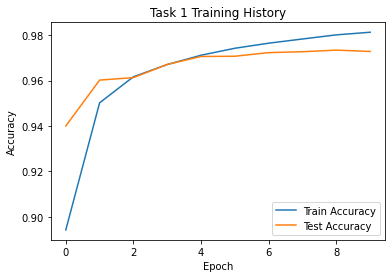

In [45]:
# Plot Training Accuracy History
plotHist1 = True
saveHist1 = False

if runTask1 and plotHist1:
    plt.plot(histMod1.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod1.history['val_accuracy'], label = 'Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Task 1 Training History')
    plt.legend(loc='lower right')
    
    if saveHist1:
       plt.savefig('HistoryT1.png',bbox_inches='tight')

In [46]:
# Display Mismatches
displayMisMatch1 = True
if runTask1 and displayMisMatch1:
   display_mismatch(x_test, y_test, t1Model)

Displaying 272 mismatches
Press q to exit at any time...
Done


Numbers of Mismatches Per Class: [10.  9. 28. 22. 39. 30. 18. 44. 32. 40.]
Distributions of Bad Guesses: 
0: [0. 1. 2. 0. 1. 2. 0. 1. 2. 1.] (Total: 10)
1: [0. 0. 1. 1. 0. 0. 1. 0. 6. 0.] (Total: 9)
2: [ 6.  0.  0. 15.  0.  0.  1.  2.  4.  0.] (Total: 28)
3: [ 0.  0.  3.  0.  0.  3.  0.  1. 11.  4.] (Total: 22)
4: [ 2.  3.  0.  1.  0.  0.  6.  4.  0. 23.] (Total: 39)
5: [ 2.  1.  1. 12.  0.  0.  4.  0.  7.  3.] (Total: 30)
6: [9. 2. 1. 1. 0. 1. 0. 0. 3. 1.] (Total: 18)
7: [ 0.  3. 14.  8.  3.  0.  0.  0.  3. 13.] (Total: 44)
8: [ 4.  0.  1. 11.  1.  6.  1.  2.  0.  6.] (Total: 32)
9: [ 2.  3.  1. 13. 10.  3.  0.  5.  3.  0.] (Total: 40)


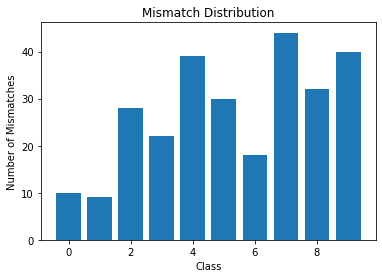

In [47]:
# Display Mismatch Stats
displayMisStats1 = True
if runTask1 and displayMisStats1:
   myMismatch, badMismatch = calculate_mismatch(x_test, y_test, t1Model)

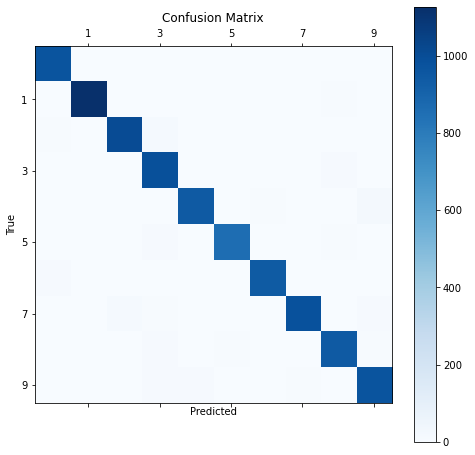

In [48]:
# Plot Confusion Matrix
plotConf1 = True
if runTask1 and plotConf1:
    y_predict1 = tf.nn.softmax(t1Model(x_test))
    y_classes1 = classes[np.argmax(y_predict1, axis=1)]
    cm1 = confusion_matrix(y_test,y_classes1)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm1, cmap=plt.cm.Blues)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [49]:
# Train PDP
trainPDP1 = True
savePDP1 = False
fileModPDP1 = "./save/t1PDP.json"
fileWgtPDP1 = "./save/t1PDP.h5"

if runTask1:
    if trainPDP1:
        nEpochs=8
        printSummaryt1 = False
        t1ModPDP = pdp_setup(nShape=nImage)
        
        if printSummaryt1:
            t1ModPDP.summary()
    
        histPDP1 = t1ModPDP.fit(x_train[:,:,:,0], y_train, 
                          epochs=nEpochs,
                          validation_data=(x_test[:,:,:,0], y_test))
        loss, accuracy = t1ModPDP.evaluate(x_test[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if savePDP1:
            with open(fileModPDP1, "w") as json_file:
                json_file.write(t1ModPDP.to_json())
                t1ModPDP.save_weights(fileWgtPDP1)
                print("Saved Task 1 PDP Model to disk")
            
    else:
        json_file = open(fileModPDP1, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        t1ModPDP = models.model_from_json(loaded_model_json)
        t1ModPDP.load_weights(fileWgtPDP1)
        print("Loaded Task 1 PDP Model from disk") 
            
        pdp_compile(t1ModPDP)
        loss1PDPTr, acc1PDPTr = t1ModPDP.evaluate(x_train[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc1PDPTr*100.))
        loss1PDP, acc2PDP = t1ModPDP.evaluate(x_test[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc1PDP*100.))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 9s 157us/sample - loss: 0.2443 - accuracy: 0.9284 - val_loss: 0.1053 - val_accuracy: 0.9673
Epoch 2/8
60000/60000 [==============================] - 10s 163us/sample - loss: 0.1100 - accuracy: 0.9664 - val_loss: 0.0818 - val_accuracy: 0.9748
Epoch 3/8
60000/60000 [==============================] - 10s 163us/sample - loss: 0.0786 - accuracy: 0.9758 - val_loss: 0.0734 - val_accuracy: 0.9771
Epoch 4/8
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0631 - accuracy: 0.9799 - val_loss: 0.0651 - val_accuracy: 0.9792
Epoch 5/8
60000/60000 [==============================] - 10s 167us/sample - loss: 0.0504 - accuracy: 0.9835 - val_loss: 0.0679 - val_accuracy: 0.9782
Epoch 6/8
60000/60000 [==============================] - 10s 169us/sample - loss: 0.0422 - accuracy: 0.9862 - val_loss: 0.0642 - val_accuracy: 0.9805
Epoch 7/8
60000/60000 [============================

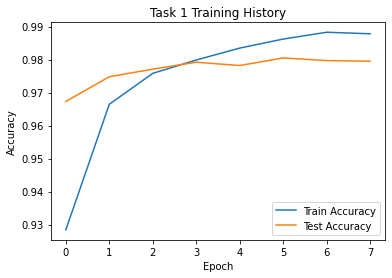

In [50]:
# Plot Training History
plotHist1 = True
saveHist1 = False

if runTask1 and plotHist1:
    plt.plot(histPDP1.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP1.history['val_accuracy'], label = 'Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Task 1 Training History')
    plt.legend(loc='lower right')
    
    if saveHist1:
        plt.savefig('HistoryPDP1.png',bbox_inches='tight')

In [51]:
# Display Mismatches
displayMisMatch1 = True
if runTask1 and displayMisMatch1:
   display_mismatch(x_test, y_test, t1ModPDP)

Displaying 205 mismatches
Press q to exit at any time...
Done


Numbers of Mismatches Per Class: [11. 10.  8. 19. 14. 23. 20. 41. 35. 24.]
Distributions of Bad Guesses: 
0: [0. 1. 5. 0. 0. 1. 2. 1. 1. 0.] (Total: 11)
1: [0. 0. 5. 3. 0. 1. 1. 0. 0. 0.] (Total: 10)
2: [1. 0. 0. 1. 1. 0. 0. 3. 2. 0.] (Total: 8)
3: [0. 0. 8. 0. 0. 2. 0. 1. 2. 6.] (Total: 19)
4: [1. 0. 4. 0. 0. 0. 3. 0. 0. 6.] (Total: 14)
5: [ 3.  0.  0. 11.  2.  0.  2.  0.  2.  3.] (Total: 23)
6: [6. 4. 0. 1. 2. 7. 0. 0. 0. 0.] (Total: 20)
7: [ 3.  5. 19.  3.  1.  0.  0.  0.  2.  8.] (Total: 41)
8: [ 2.  3. 11.  6.  2.  5.  0.  2.  0.  4.] (Total: 35)
9: [2. 3. 0. 8. 6. 3. 0. 1. 1. 0.] (Total: 24)


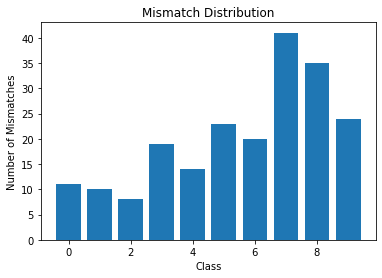

In [52]:
# Display Mismatch Stats
displayMisStats1 = True
if runTask1 and displayMisStats1:
   myMismatch, badMismatch = calculate_mismatch(x_test, y_test, t1ModPDP)

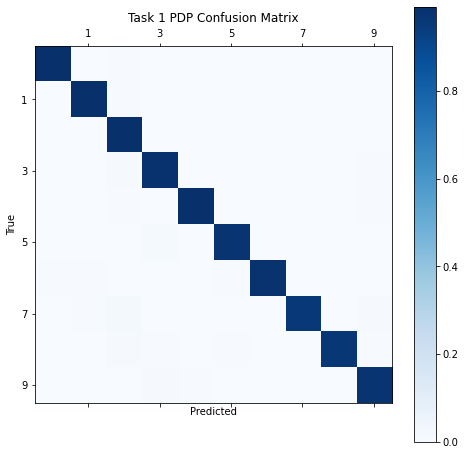

In [53]:
# Plot Confusion Matrix
plotConf1 = True
if runTask1 and plotConf1:
    y_predict1 = tf.nn.softmax(t1ModPDP(x_test))
    y_classes1 = classes[np.argmax(y_predict1, axis=1)]
    cm1 = confusion_matrix(y_test,y_classes1,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm1, cmap=plt.cm.Blues)
    ax.set_title("Task 1 PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task 2: Random Digit Placement--

In [54]:
runTask2 = True

### Create New Images

In [55]:
# Create new images
if runTask2:
    nImageNew = nImage*2

    x_train2 = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)
        x_train2[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_train[i,:,:,0]

    x_test2 = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)
        x_test2[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_test[i,:,:,0]
        
    print('Created Dataset for Task 2.')

Created Dataset for Task 2.


In [ ]:
# Plot sample image
plotSample2 = False
if runTask2 and plotSample2:
    imSample = randint(0,nTest-1)
    imToPlot = x_test2[imSample,:,:,0]
    print("Plotting Image {}".format(imSample))
    plt.imshow(imToPlot,cmap='gray')

### CNN

In [56]:
# Train CNN
trainModel2 = False
saveModel2 = True
fileModel2 = './save/t2CNN.json'
fileWghts2 = './save/t2CNN.h5'

if runTask2:
    if trainModel2:
        nEpochs=8
        nBSize=128
        t2Model = cnn_setup(nShape=nImageNew)
        if False:
            t2Model.summary()
    
        histMod2 = t2Model.fit(x_train2, y_train, 
                          batch_size=nBSize, epochs=nEpochs,
                          validation_data=(x_test2, y_test))
        loss, accuracy = t2Model.evaluate(x_test2,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel2:
            with open(fileModel2, "w") as json_file:
                json_file.write(t2Model.to_json())
                t2Model.save_weights(fileWghts2)
                print("Saved Task 2 CNN Model to disk")
                
    else:
        json_file = open(fileModel2, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        t2Model = models.model_from_json(loaded_model_json)
        t2Model.load_weights(fileWghts2)
        print("Loaded Task 2 CNN Model from disk")
        
        cnn_compile(t2Model)
        loss2ModTr, acc2ModTr = t2Model.evaluate(x_train2, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc2ModTr*100.))
        loss2Mod, acc2Mod = t2Model.evaluate(x_test2, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc2Mod*100.))

Loaded Task 2 CNN Model from disk
  Train Accuracy: 97.377
  Test Accuracy : 97.780


In [58]:
# Plot Training History
plotHist2 = True
saveHist2 = False
if trainModel2 and plotHist2:
    plt.plot(histMod2.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod2.history['val_accuracy'], label = 'Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Task 2 Training History')
    plt.legend(loc='lower right')
    
    if saveHist2:
        plt.savefig('HistoryT2.png',bbox_inches='tight')

In [60]:
# Display Mismatches
displayMisMatch2 = False
if runTask2 and displayMisMatch2:
   display_mismatch(x_test2, y_test, t2Model)

Numbers of Mismatches Per Class: [15.  8. 15. 18. 24. 24. 24. 38. 31. 25.]
Distributions of Bad Guesses: 
0: [0. 1. 4. 1. 0. 1. 2. 1. 3. 2.] (Total: 15)
1: [0. 0. 4. 0. 1. 0. 1. 2. 0. 0.] (Total: 8)
2: [4. 0. 0. 2. 2. 1. 0. 4. 2. 0.] (Total: 15)
3: [0. 0. 5. 0. 0. 5. 0. 2. 2. 4.] (Total: 18)
4: [ 0.  3.  2.  0.  0.  0.  2.  3.  1. 13.] (Total: 24)
5: [1. 1. 1. 8. 2. 0. 2. 1. 3. 5.] (Total: 24)
6: [4. 5. 3. 0. 2. 3. 0. 0. 7. 0.] (Total: 24)
7: [ 1.  5. 11.  3.  5.  1.  0.  0.  2. 10.] (Total: 38)
8: [ 5.  0.  6.  2.  2.  1.  5.  0.  0. 10.] (Total: 31)
9: [3. 1. 2. 5. 8. 0. 0. 4. 2. 0.] (Total: 25)


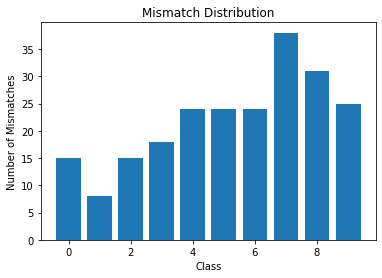

In [61]:
# Display Mismatch Stats
displayMisStats2 = True
if runTask2 and displayMisStats2:
   myMismatch, badMismatch = calculate_mismatch(x_test2, y_test, t2Model)

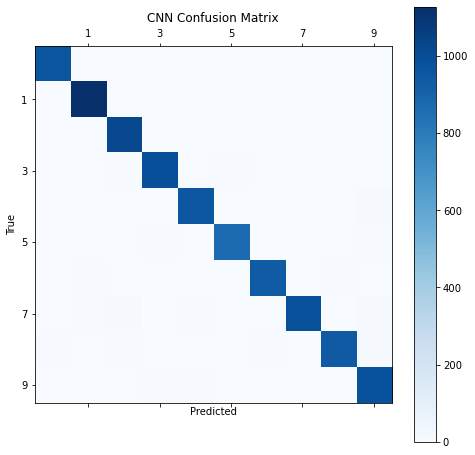

In [62]:
# Plot Confusion Matrix
plotConf2 = True
if runTask2 and plotConf2:
    y_predict2 = tf.nn.softmax(t2Model(x_test2))
    y_classes2 = classes[np.argmax(y_predict2, axis=1)]
    cm2 = confusion_matrix(y_test,y_classes2)
    #print(cm2)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm2, cmap=plt.cm.Blues)
    ax.set_title("CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [63]:
# Train PDP
trainPDP2 = False
savePDP2 = False
fileModPDP2 = "./save/t2PDP.json"
fileWgtPDP2 = "./save/t2PDP.h5"

if runTask2:
    if trainPDP2:
        nEpochs=10
        printSummaryt2 = False
        t2ModPDP = pdp_setup(nShape=nImageNew)
        
        if printSummaryt2:
            t2ModPDP.summary()
    
        histPDP2 = t2ModPDP.fit(x_train2[:,:,:,0], y_train, 
                          epochs=nEpochs,
                          validation_data=(x_test2[:,:,:,0], y_test))
        loss, accuracy = t2ModPDP.evaluate(x_test2[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if savePDP2:
            with open(fileModPDP2, "w") as json_file:
                json_file.write(t2ModPDP.to_json())
                t2ModPDP.save_weights(fileWgtPDP2)
                print("Saved Task 2 PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP2, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t2ModPDP = models.model_from_json(loaded_model_json)
        t2ModPDP.load_weights(fileWgtPDP2)
        print("Loaded Task 2 PDP Model from disk") 
            
        pdp_compile(t2ModPDP)
        loss2PDPTr, acc2PDPTr = t2ModPDP.evaluate(x_train2[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc2PDPTr*100.))
        loss2PDP, acc2PDP = t2ModPDP.evaluate(x_test2[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc2PDP*100.))

Loaded Task 2 PDP Model from disk
  Train Accuracy: 87.125
  Test Accuracy : 87.600


In [64]:
# Plot Training History
plotHist2 = True
saveHist2 = True

if runTask2 and trainPDP2 and plotHist2:
    plt.plot(histPDP2.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP2.history['val_accuracy'], label = 'Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Task 2 Training History')
    plt.legend(loc='lower right')
    
    if saveHist2:
        plt.savefig('HistoryPDP2.png',bbox_inches='tight')

In [65]:
# Display Mismatches
displayMisMatch2 = False
if runTask2 and displayMisMatch2:
   display_mismatch(x_test2, y_test, t2ModPDP)

Numbers of Mismatches Per Class: [ 88.  23. 135. 201. 136. 150.  75. 162. 135. 135.]
Distributions of Bad Guesses: 
0: [ 0.  1.  9.  3.  5. 15. 15.  3. 33.  4.] (Total: 88)
1: [0. 0. 4. 3. 2. 0. 3. 0. 9. 2.] (Total: 23)
2: [13.  6.  0. 30.  7. 14. 29. 13. 20.  3.] (Total: 135)
3: [10.  6. 38.  0.  2. 57.  0. 16. 51. 21.] (Total: 201)
4: [ 1.  2.  7.  0.  0.  0. 27.  2.  4. 93.] (Total: 136)
5: [10.  5. 17. 44.  2.  0. 10.  9. 37. 16.] (Total: 150)
6: [14.  9.  2.  0. 22. 11.  0.  0. 17.  0.] (Total: 75)
7: [ 2. 12. 26. 15.  4.  8.  0.  0.  8. 87.] (Total: 162)
8: [14. 10.  5. 21. 12. 28. 13.  4.  0. 28.] (Total: 135)
9: [ 8.  9.  3.  8. 47.  8.  4. 21. 27.  0.] (Total: 135)


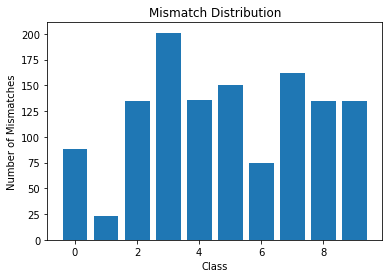

In [66]:
# Display Mismatch Stats
displayMisStats2 = True
if runTask2 and displayMisStats2:
   myMismatch, badMismatch = calculate_mismatch(x_test2, y_test, t2ModPDP)

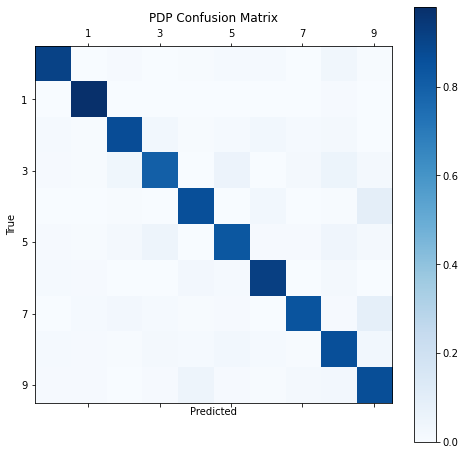

In [67]:
# Plot Confusion Matrix
plotConf2 = True
if runTask2 and plotConf2:
    y_predict2 = tf.nn.softmax(t2ModPDP(x_test2))
    y_classes2 = classes[np.argmax(y_predict2, axis=1)]
    cm2 = confusion_matrix(y_test,y_classes2,normalize='true')
    #print(cm2)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm2, cmap=plt.cm.Blues)
    ax.set_title("PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task 3: Top versus Bottom--

In [68]:
runTask3 = True

### Create New Images

In [69]:
# Create new images
if runTask3:
    nImageNew = nImage*2

    x_train3 = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        xstart = 0
        ystart = randint(0,nImage)
        x_train3[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_train[i,:,:,0]

    x_test3 = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        xstart = nImage
        ystart = randint(0,nImage)
        x_test3[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_test[i,:,:,0]
        
    print('Created dataset for Task 3.')

Created dataset for Task 3.


Plotting Training Image 8912
Plotting Testing Image 8368


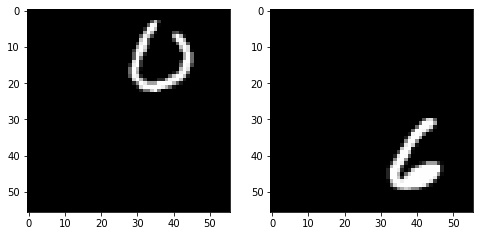

In [70]:
# Plot sample image
plotSample3 = True
if runTask3 and plotSample3:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train3[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(1,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    
    imToPlot = x_test3[imSample2,:,:,0]
    ax2 = plt.subplot(1,2,2)
    ax2.imshow(imToPlot,cmap='gray')

### CNN

In [71]:
# Train CNN
trainModel3 = False
saveModel3 = False
fileModel3 = './save/t3CNN.json'
fileWghts3 = './save/t3CNN.h5'

if runTask3:
    if trainModel3:
        nEpochs=10
        nBSize=128
        showSummary3 = False
        t3Model = cnn_setup(nShape=nImageNew)
    
        if showSummary3:
            t3Model.summary()
    
        histMod3 = t3Model.fit(x_train3, y_train, 
                          batch_size=nBSize, epochs=nEpochs,
                          validation_data=(x_test3, y_test))
        loss, accuracy = t3Model.evaluate(x_test3,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel3:
            with open(fileModel3, "w") as json_file:
                json_file.write(t3Model.to_json())
                t3Model.save_weights(fileWghts3)
                print("Saved Task 3 CNN Model to disk")
                
    else:
        json_file = open(fileModel3, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        t3Model = models.model_from_json(loaded_model_json)
        t3Model.load_weights(fileWghts3)
        print("Loaded Task 3 CNN Model from disk")
        
        cnn_compile(t3Model)
        loss3ModTr, acc3ModTr = t3Model.evaluate(x_train3, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc3ModTr*100.))
        loss3Mod, acc3Mod = t3Model.evaluate(x_test3, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc3Mod*100.))

Loaded Task 3 CNN Model from disk
  Train Accuracy: 98.850
  Test Accuracy : 11.840


In [73]:
# Plot Training History
plotHist3 = True
saveHist3 = True

if runTask3 and trainModel3 and plotHist3:
    plt.plot(histMod3.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod3.history['val_accuracy'], label = 'Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Task 3 Training History')
    plt.legend(loc='center right')
    
    if saveHist3:
        plt.savefig('HistoryT3.png',bbox_inches='tight')

In [75]:
# Display Mismatches
displayMisMatch3 = False
if runTask3 and displayMisMatch3:
   display_mismatch(x_test3, y_test, t3Model)

Numbers of Mismatches Per Class: [ 980.  553. 1032. 1006.  982.  891.  958.  956.  958.  500.]
Distributions of Bad Guesses: 
0: [  0. 386.   0. 251.   0. 168.   0.  17.   0. 158.] (Total: 980)
1: [  0.   0.   0.  64.   0. 480.   0.   0.   6.   3.] (Total: 553)
2: [  0. 307.   0. 168.   2. 104.   0.  73. 258. 120.] (Total: 1032)
3: [  0. 155.   0.   0.   0.  15.   0. 203. 340. 293.] (Total: 1006)
4: [  0. 514.   0.   9.   0. 396.   0.   1.   3.  59.] (Total: 982)
5: [  0. 378.   0.  19.  17.   0.   0. 141.  15. 321.] (Total: 891)
6: [  0. 900.   0.  15.   0.  29.   0.   2.   1.  11.] (Total: 958)
7: [  0. 193.   0.  98.   1.  90.   0.   0. 100. 474.] (Total: 956)
8: [  0. 155.   0. 195.   0.  29.   0. 211.   0. 368.] (Total: 958)
9: [  0. 231.   0.  39.   0.  20.   0. 205.   5.   0.] (Total: 500)


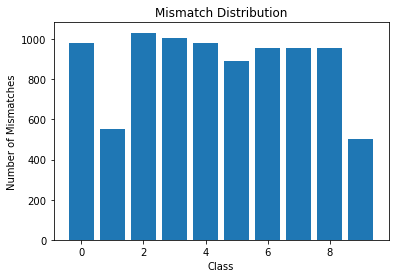

In [76]:
# Display Mismatch Stats
displayMisStats3 = True
if runTask3 and displayMisStats3:
   myMismatch, badMismatch = calculate_mismatch(x_test3, y_test, t3Model)

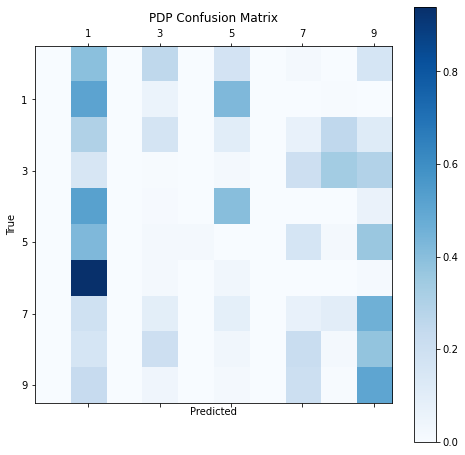

In [77]:
# Plot Confusion Matrix
plotConf3 = True
if runTask3 and plotConf3:
    y_predict3 = tf.nn.softmax(t3Model(x_test3))
    y_classes3 = classes[np.argmax(y_predict3, axis=1)]
    cm3 = confusion_matrix(y_test,y_classes3,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm3, cmap=plt.cm.Blues)
    ax.set_title("PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

conv2d (3, 3, 1, 32)
conv2d_2 (3, 3, 64, 64)


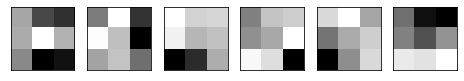

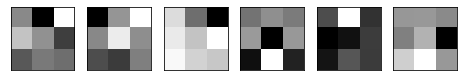

In [79]:
# Plot CNN Layer Weights
plotWeights = True
saveL0Weights = 'T3L0Weights.png'
saveL2Weights = 'T3L2Weights.png'
if runTask3 and plotWeights:
    cnn_L0weights(t3Model,File=saveL0Weights)
    cnn_L2weights(t3Model,File=saveL2Weights)

TRUTH: 6, PREDICTED: 6
Feature Map Dimension:  (1, 54, 54, 32)
Feature Map Dimension:  (1, 10, 10, 64)
Feature Map Dimension:  (1, 64)
Feature Map Dimension:  (1, 10)


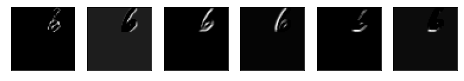

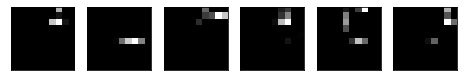

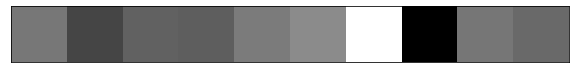

In [80]:
# Plot CNN Train Layer Activations
plotActivations = True
saveL0Activations = 'T3L0As.png'
saveL2Activations = 'T3L2As.png'
saveL6Activations = 'T3L6As.png'
saveL7Activations = 'T3L7As.png'
if runTask3 and plotActivations:
    my6Tr = 11959
    mySample = x_train3[my6Tr:my6Tr+1,:,:,0:1]
    y_predict = tf.nn.softmax(t3Model(mySample))
    y_class = classes[np.argmax(y_predict, axis=1)][0]
    print("TRUTH: {}, PREDICTED: {}".format(y_train[my6Tr],y_class))
    
    cnn_L0activations(t3Model,mySample,File=saveL0Activations)
    cnn_L2activations(t3Model,mySample,File=saveL2Activations)
    cnn_L6activations(t3Model,mySample,File=saveL6Activations)
    cnn_L7activations(t3Model,mySample,File=saveL7Activations)

TRUTH: 6, PREDICTED: 1
Feature Map Dimension:  (1, 54, 54, 32)
Feature Map Dimension:  (1, 10, 10, 64)
Feature Map Dimension:  (1, 64)
Feature Map Dimension:  (1, 10)


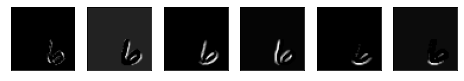

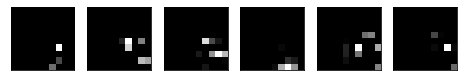

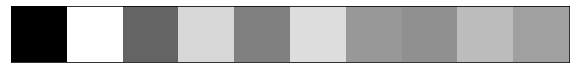

In [81]:
# Plot CNN Test Layer Activations
plotTestActivations = True
saveL0Activations = 'T3L0ATs.png'
saveL2Activations = 'T3L2ATs.png'
saveL6Activations = 'T3L6ATs.png'
saveL7Activations = 'T3L7ATs.png'
if runTask3 and plotTestActivations:
    my6Te = 138
    mySample = x_test3[my6Te:my6Te+1,:,:,0:1]
    y_predict = tf.nn.softmax(t3Model(mySample))
    y_class = classes[np.argmax(y_predict, axis=1)][0]
    print("TRUTH: {}, PREDICTED: {}".format(y_test[my6Te],y_class))
    
    cnn_L0activations(t3Model,mySample,File=saveL0Activations)
    cnn_L2activations(t3Model,mySample,File=saveL2Activations)
    cnn_L6activations(t3Model,mySample,File=saveL6Activations)
    cnn_L7activations(t3Model,mySample,File=saveL7Activations)

### PDP Neural Network

In [82]:
# Train PDP 
trainPDP3 = False
savePDP3 = False
fileModPDP3 = "./save/t3PDP.json"
fileWgtPDP3 = "./save/t3PDP.h5"

if runTask3:
    if trainPDP3:
        nEpochs=8
        showSummary3 = False
        t3ModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary3:
            t3ModPDP.summary()
    
        histPDP3 = t3ModPDP.fit(x_train3[:,:,:,0], y_train, 
                          epochs=nEpochs,
                          validation_data=(x_test3[:,:,:,0], y_test))
        loss, accuracy = t3ModPDP.evaluate(x_test3[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if savePDP3:
            with open(fileModPDP3, "w") as json_file:
                json_file.write(t3ModPDP.to_json())
                t3ModPDP.save_weights(fileWgtPDP3)
                print("Saved Task 3 PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP3, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t3ModPDP = models.model_from_json(loaded_model_json)
        t3ModPDP.load_weights(fileWgtPDP3)
        print("Loaded Task 3 PDP Model from disk") 
            
        pdp_compile(t3ModPDP)
        loss3PDPTr, acc3PDPTr = t3ModPDP.evaluate(x_train3[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc3PDPTr*100.))
        loss3PDP, acc3PDP = t3ModPDP.evaluate(x_test3[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc3PDP*100.))

Loaded Task 3 PDP Model from disk
  Train Accuracy: 95.388
  Test Accuracy : 8.130


In [83]:
# Plot Training History
plotHist3 = True
saveHist3 = True
if runTask3 and trainPDP3 and plotHist3:
    plt.plot(histPDP3.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP3.history['val_accuracy'], label = 'Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Task 3 Training History')
    plt.legend(loc='center right')
    
    if saveHist3:
        plt.savefig('HistoryPDP3.png',bbox_inches='tight')

In [84]:
# Display Mismatches
displayMisMatch3 = False
if runTask3 and displayMisMatch3:
   display_mismatch(x_test3, y_test, t3ModPDP)

Numbers of Mismatches Per Class: [ 980. 1105. 1032. 1010.  982.  109.  958. 1028.  974. 1009.]
Distributions of Bad Guesses: 
0: [  0. 179.   0.   0.   0. 800.   0.   1.   0.   0.] (Total: 980)
1: [   0.    0.    0.    0.    0. 1105.    0.    0.    0.    0.] (Total: 1105)
2: [  0.  93.   0.   0.   0. 939.   0.   0.   0.   0.] (Total: 1032)
3: [  0. 210.   0.   0.   0. 800.   0.   0.   0.   0.] (Total: 1010)
4: [  0.  60.   0.   0.   0. 922.   0.   0.   0.   0.] (Total: 982)
5: [  0. 109.   0.   0.   0.   0.   0.   0.   0.   0.] (Total: 109)
6: [  0.  20.   0.   0.   0. 938.   0.   0.   0.   0.] (Total: 958)
7: [  0. 184.   0.   0.   0. 844.   0.   0.   0.   0.] (Total: 1028)
8: [  0. 147.   0.   0.   0. 827.   0.   0.   0.   0.] (Total: 974)
9: [  0. 132.   0.   0.   0. 877.   0.   0.   0.   0.] (Total: 1009)


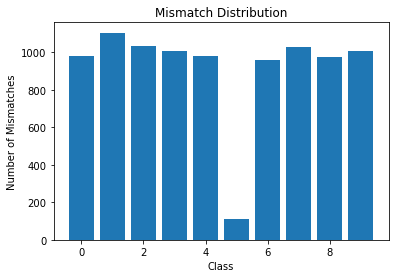

In [85]:
# Display Mismatch Stats
displayMisStats3 = True
if runTask3 and displayMisStats3:
   myMismatch, badMismatch = calculate_mismatch(x_test3, y_test, t3ModPDP)

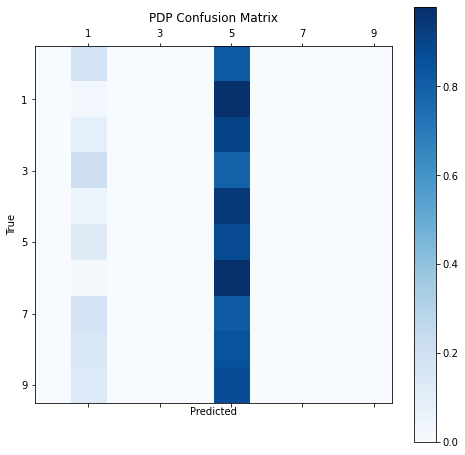

In [86]:
# Plot Confusion Matrix
plotConf3 = True
if runTask3 and plotConf3:
    y_predict3 = tf.nn.softmax(t3ModPDP(x_test3))
    y_classes3 = classes[np.argmax(y_predict3, axis=1)]
    cm3 = confusion_matrix(y_test,y_classes3,normalize='true')
    #print(cm2)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm3, cmap=plt.cm.Blues)
    ax.set_title("PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task4A: Resize--

In [87]:
runTask4a = True

### Create New Images

In [88]:
# Create new images
if runTask4a:
    nImageNew = nImage*2

    x_train4a = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        fSize = uniform(0.4,2.0)
        #print("Rescaling Factor: {:.3f}".format(fSize))
        nImReSize = int(nImage*fSize)
        newDim = (nImReSize,nImReSize)
        resized = cv2.resize(x_train[i,:,:,0], newDim)

        xstart = randint(0,(nImageNew-nImReSize))
        ystart = randint(0,(nImageNew-nImReSize))
        x_train4a[i,xstart:xstart+nImReSize,ystart:ystart+nImReSize,0] = resized[:,:]

    x_test4a = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        fSize = uniform(0.3,1.7)
        nImReSize = int(nImage*fSize)
        newDim = (nImReSize,nImReSize)
        resized = cv2.resize(x_test[i,:,:,0], newDim)

        xstart = randint(0,(nImageNew-nImReSize))
        ystart = randint(0,(nImageNew-nImReSize))
        x_test4a[i,xstart:xstart+nImReSize,ystart:ystart+nImReSize,0] = resized[:,:]
        
    print("Created Dataset for Task 4A.")

Created Dataset for Task 4A.


In [89]:
# Plot sample images
plotSample4 = False
if runTask4a and plotSample4:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    ax1.set_title("Original Train")
    
    imToPlot = x_train4[imSample1,:,:,0]
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(imToPlot,cmap='gray')
    ax2.set_title("New Train")
    
    imToPlot = x_test[imSample2,:,:,0]
    ax3 = plt.subplot(2,2,3)
    ax3.imshow(imToPlot,cmap='gray')
    ax3.set_title("Orig Test")
    
    imToPlot = x_test4[imSample2,:,:,0]
    ax4 = plt.subplot(2,2,4)
    ax4.imshow(imToPlot,cmap='gray')
    ax4.set_title("New Test")
    

### CNN

In [90]:
# Train CNN
trainModel4a = False
saveModel4a = False
fileModel4a = './save/t4aCNN.json'
fileWghts4a = './save/t4aCNN.h5'

if runTask4a:
    if trainModel4a:
        nEpochs=10
        showSummary4a = False
        t4aModel = cnn_setup(nShape=nImageNew)
    
        if showSummary4a:
            t4aModel.summary()
    
        histMod4a = t4aModel.fit(x_train4a, y_train, 
                              epochs=nEpochs,
                              validation_data=(x_test4a, y_test))
        loss, accuracy = t4aModel.evaluate(x_test4a,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel4a:
            # serialize model to JSON and save weights
            with open(fileModel4a, "w") as json_file:
                json_file.write(t4aModel.to_json())
                t4aModel.save_weights(fileWghts4a)
                print("Saved Task 4A CNN Model to disk")
                
    else:
        json_file4 = open(fileModel4a, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4aModel = models.model_from_json(loaded_model_json)
        t4aModel.load_weights(fileWghts4a)
        print("Loaded Task 4A CNN Model from disk")
        
        cnn_compile(t4aModel)
        loss4aModTr, acc4aModTr = t4aModel.evaluate(x_train4a, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4aModTr*100.))
        loss4aMod, acc4aMod = t4aModel.evaluate(x_test4a, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4aMod*100.))

Loaded Task 4A CNN Model from disk
  Train Accuracy: 96.387
  Test Accuracy : 93.660


In [92]:
# Plot Training History
plotTaskHist4a = True
saveTaskHist4a = True
if runTask4a and trainModel4a and plotTaskHist4a:
    plt.plot(histMod4a.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod4a.history['val_accuracy'], label = 'Test Accuracy')
    plt.title('Model History Task 4A')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskHist4a:
        plt.savefig('HistoryT4A.png',bbox_inches='tight')

In [93]:
# Display Mismatches
displayMisMatch4a = False
if runTask4a and displayMisMatch4a:
   display_mismatch(x_test4a, y_test, t4aModel)

Numbers of Mismatches Per Class: [53. 17. 72. 68. 48. 73. 57. 67. 81. 98.]
Distributions of Bad Guesses: 
0: [ 0.  1. 11.  0.  4.  2. 14.  0. 16.  5.] (Total: 53)
1: [0. 0. 4. 1. 6. 0. 4. 1. 0. 1.] (Total: 17)
2: [ 3.  2.  0. 34.  6.  5.  3.  6.  8.  5.] (Total: 72)
3: [ 2.  0. 23.  0.  3. 11.  1.  8. 16.  4.] (Total: 68)
4: [ 2.  4.  5.  1.  0.  2.  5.  4. 12. 13.] (Total: 48)
5: [ 6.  2.  6. 23.  2.  0.  8.  0. 20.  6.] (Total: 73)
6: [17. 12.  1.  0. 12.  7.  0.  0.  8.  0.] (Total: 57)
7: [ 1.  5. 30.  8.  9.  0.  0.  0.  3. 11.] (Total: 67)
8: [ 9.  2. 11.  4.  6.  4. 18.  4.  0. 23.] (Total: 81)
9: [ 5.  4. 10.  9. 26.  4.  0. 18. 22.  0.] (Total: 98)


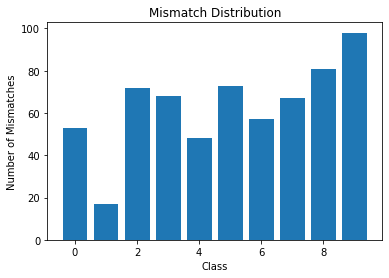

In [94]:
# Display Mismatch Stats
displayMisStats4a = True
if runTask4a and displayMisStats4a:
   myMismatch, badMismatch = calculate_mismatch(x_test4a, y_test, t4aModel)

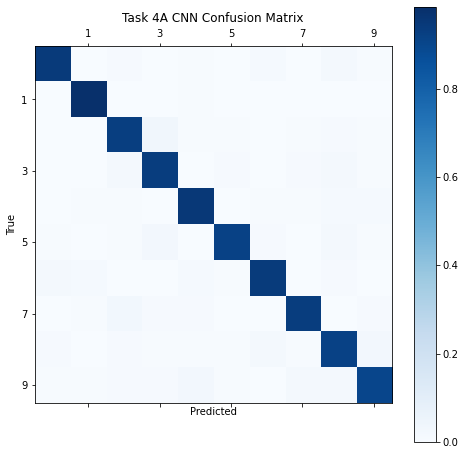

In [95]:
# Plot Confusion Matrix
plotConf4a = True

if runTask4a and plotConf4a:
    y_predict4a = tf.nn.softmax(t4aModel(x_test4a))
    y_classes4a = classes[np.argmax(y_predict4a, axis=1)]
    cm4a= confusion_matrix(y_test,y_classes4a,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4a, cmap=plt.cm.Blues)
    ax.set_title("Task 4A CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [96]:
# Train PDP 
trainPDP4a = False
savePDP4a = False
fileModPDP4a = "./save/t4aPDP.json"
fileWgtPDP4a = "./save/t4aPDP.h5"

if runTask4a:
    if trainPDP4a:
        nEpochs=10
        showSummary4a = False
        t4aModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary4a:
            t4aModPDP.summary()
    
        histPDP4a = t4aModPDP.fit(x_train4a[:,:,:,0], y_train, epochs=nEpochs, 
                                validation_data=(x_test4a[:,:,:,0], y_test))
        loss, accuracy = t4aModPDP.evaluate(x_test4a[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
    
        if savePDP4a:
            # serialize model to JSON and save weights
            with open(fileModPDP4a, "w") as json_file:
                json_file.write(t4aModPDP.to_json())
                t4aModPDP.save_weights(fileWgtPDP4a)
                print("Saved Task 4A PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP4a, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4aModPDP = models.model_from_json(loaded_model_json)
        t4aModPDP.load_weights(fileWgtPDP4a)
        print("Loaded Task 4A PDP Model from disk") 
            
        pdp_compile(t4aModPDP)
        loss4aPDPTr, acc4aPDPTr = t4aModPDP.evaluate(x_train4a[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4aPDPTr*100.))
        loss4aPDP, acc4aPDP = t4aModPDP.evaluate(x_test4a[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4aPDP*100.))

Loaded Task 4A PDP Model from disk
  Train Accuracy: 74.650
  Test Accuracy : 66.620


In [97]:
# Plot Training History
plotHist4a = False
saveHist4a = False

if runTask4a and trainPDP4a and plotHist4a:
    plt.plot(histPDP4a.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP4a.history['val_accuracy'], label = 'Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Task 4A PDP Training History')
    plt.legend(loc='lower right')
    
    if saveHist4a:
        plt.savefig('HistoryPDP4.png',bbox_inches='tight')

In [98]:
# Display Mismatches
displayMisMatch4 = False
if runTask4a and displayMisMatch4:
   display_mismatch(x_test4, y_test, t4ModPDP)

Numbers of Mismatches Per Class: [316. 119. 355. 407. 303. 358. 311. 298. 468. 403.]
Distributions of Bad Guesses: 
0: [ 0.  6. 49. 35. 43. 53. 42. 12. 42. 34.] (Total: 316)
1: [ 6.  0.  3.  8. 16.  9. 12. 26. 20. 19.] (Total: 119)
2: [27. 22.  0. 91. 38. 46. 43. 32. 35. 21.] (Total: 355)
3: [20. 40. 67.  0. 38. 70. 13. 45. 63. 51.] (Total: 407)
4: [17. 16. 44. 11.  0. 22. 37. 44. 18. 94.] (Total: 303)
5: [27. 20. 48. 83. 32.  0. 21. 37. 55. 35.] (Total: 358)
6: [38. 20. 59. 11. 99. 39.  0.  9. 20. 16.] (Total: 311)
7: [ 8. 48. 20. 47. 41. 22.  1.  0. 14. 97.] (Total: 298)
8: [ 40.  39.  18.  53.  82.  71.  35.  30.   0. 100.] (Total: 468)
9: [ 29.  36.  19.  28. 136.  24.   9.  81.  41.   0.] (Total: 403)


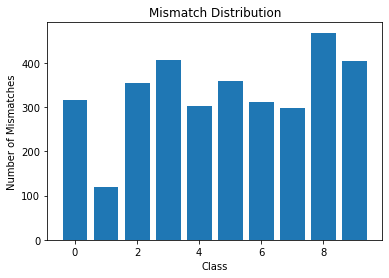

In [101]:
# Display Mismatch Stats
displayMisStats4 = True
if runTask4a and displayMisStats4:
   myMismatch, badMismatch = calculate_mismatch(x_test4a, y_test, t4aModPDP)

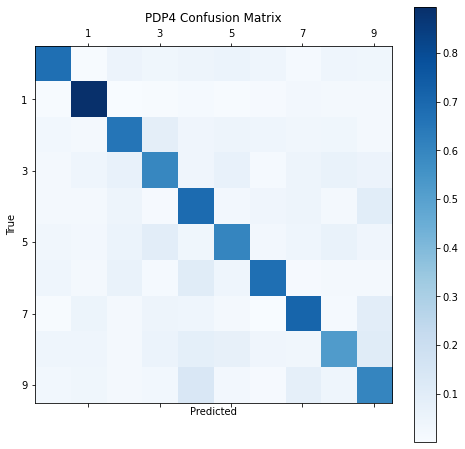

In [104]:
# Plot Confusion Matrix
plotConf4 = True
if runTask4a and plotConf4:
    y_predict4 = tf.nn.softmax(t4aModPDP(x_test4a))
    y_classes4 = classes[np.argmax(y_predict4, axis=1)]
    cm4 = confusion_matrix(y_test,y_classes4,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4, cmap=plt.cm.Blues)
    ax.set_title("PDP4 Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task4B: Flipping Only--

In [105]:
runTask4b = True

### Create New Images

In [106]:
# Create new images
if runTask4b:
    nImageNew = nImage

    x_train4b = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        fFlip = randint(0,3)
        if fFlip < 2:
            x_train4b[i,:,:,0] = x_train[i,:,:,0]
        elif fFlip == 2:
            flipped = cv2.flip(x_train[i,:,:,0], 0)
            x_train4b[i,:,:,0] = flipped[:,:]
        else:
            flipped = cv2.flip(x_train[i,:,:,0], 1)
            x_train4b[i,:,:,0] = flipped[:,:]
            
    x_test4b = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        fFlip = randint(0,3)
        if fFlip < 2:
            x_test4b[i,:,:,0] = x_test[i,:,:,0]
        elif fFlip == 2:
            flipped = cv2.flip(x_test[i,:,:,0], 0)
            x_test4b[i,:,:,0] = flipped[:,:]
        else:
            flipped = cv2.flip(x_test[i,:,:,0], 1)
            x_test4b[i,:,:,0] = flipped[:,:]
            
    print("Created Dataset for Task 4B.")

Created Dataset for Task 4B.


Plotting Training Image 51140
Plotting Testing Image 1443


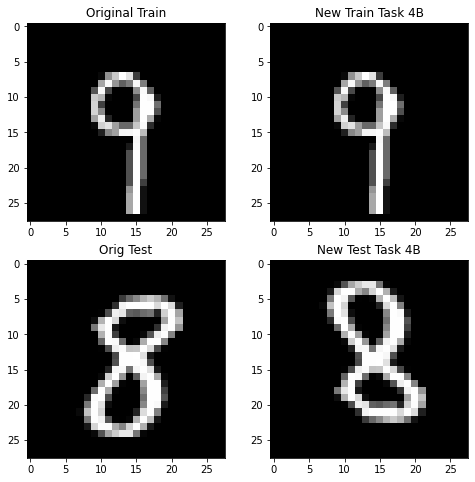

In [107]:
# Plot sample images
plotSample4b = True
if runTask4b and plotSample4b:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    ax1.set_title("Original Train")
    
    imToPlot = x_train4b[imSample1,:,:,0]
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(imToPlot,cmap='gray')
    ax2.set_title("New Train Task 4B")
    
    imToPlot = x_test[imSample2,:,:,0]
    ax3 = plt.subplot(2,2,3)
    ax3.imshow(imToPlot,cmap='gray')
    ax3.set_title("Orig Test")
    
    imToPlot = x_test4b[imSample2,:,:,0]
    ax4 = plt.subplot(2,2,4)
    ax4.imshow(imToPlot,cmap='gray')
    ax4.set_title("New Test Task 4B")
    

### CNN

In [108]:
# Train CNN
trainModel4b = False                                                                                                                                             
saveModel4b = False
fileModel4b = './save/t4bCNN.json'
fileWghts4b = './save/t4bCNN.h5'

if runTask4b:
    if trainModel4b:
        nEpochs=8
        showSummary4b = False
        t4bModel = cnn_setup(nShape=nImageNew)
    
        if showSummary4b:
            t4bModel.summary()
    
        histMod4b = t4bModel.fit(x_train4b, y_train, 
                              epochs=nEpochs,
                              validation_data=(x_test4b, y_test))
        loss, accuracy = t4bModel.evaluate(x_test4b,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel4b:
            # serialize model to JSON and save weights
            with open(fileModel4b, "w") as json_file:
                json_file.write(t4bModel.to_json())
                t4bModel.save_weights(fileWghts4b)
                print("Saved Task 4B Model to disk")
                
    else:
        json_file4 = open(fileModel4b, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4bModel = models.model_from_json(loaded_model_json)
        t4bModel.load_weights(fileWghts4b)
        print("Loaded Task 4B CNN Model from disk")
        
        cnn_compile(t4bModel)
        loss4bModTr, acc4bModTr = t4bModel.evaluate(x_train4b, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4bModTr*100.))
        loss4bMod, acc4bMod = t4bModel.evaluate(x_test4b, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4bMod*100.))

Loaded Task 4B CNN Model from disk
  Train Accuracy: 98.162
  Test Accuracy : 97.540


In [109]:
# Plot Training History
plotTaskHist4b = False
saveTaskHist4b = False
if runTask4b and trainModel4b and plotTaskHist4b:
    plt.plot(histMod4b.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod4b.history['val_accuracy'], label = 'Test Accuracy')
    plt.title('Model History Task 4B')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskHist4b:
        plt.savefig('HistoryT4B.png',bbox_inches='tight')

In [110]:
# Display Mismatches
displayMisMatch4b = False
if runTask4b and displayMisMatch4b:
   display_mismatch(x_test4b, y_test, t4bModel)

Numbers of Mismatches Per Class: [ 3. 14. 45. 23.  5. 35. 31. 31. 12. 47.]
Distributions of Bad Guesses: 
0: [0. 0. 1. 0. 0. 0. 0. 1. 1. 0.] (Total: 3)
1: [0. 0. 2. 1. 7. 0. 0. 4. 0. 0.] (Total: 14)
2: [ 1.  1.  0.  5.  0. 25.  5.  5.  1.  2.] (Total: 45)
3: [0. 0. 5. 0. 0. 7. 0. 5. 5. 1.] (Total: 23)
4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 5.] (Total: 5)
5: [ 0.  0. 20.  9.  0.  0.  2.  1.  3.  0.] (Total: 35)
6: [10.  1.  3.  0.  1.  3.  0.  5.  2.  6.] (Total: 31)
7: [ 1.  2.  6.  1.  2.  4. 10.  0.  2.  3.] (Total: 31)
8: [5. 0. 1. 1. 2. 0. 0. 0. 0. 3.] (Total: 12)
9: [ 1.  0.  2.  1.  8.  3. 16.  5. 11.  0.] (Total: 47)


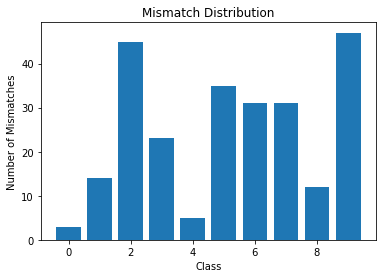

In [111]:
# Display Mismatch Stats
displayMisStats4b = True
if runTask4b and displayMisStats4b:
   myMismatch, badMismatch = calculate_mismatch(x_test4b, y_test, t4bModel)

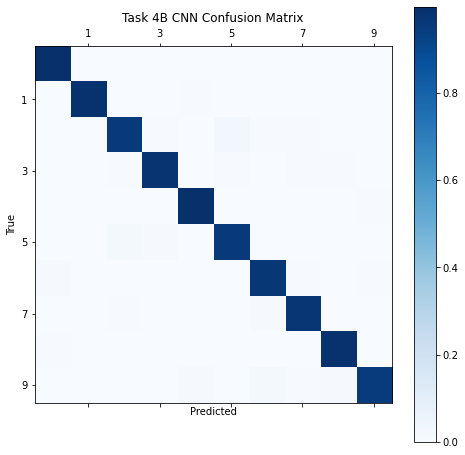

In [112]:
# Plot Confusion Matrix
plotConf4b = True

if runTask4b and plotConf4b:
    y_predict4b = tf.nn.softmax(t4bModel(x_test4b))
    y_classes4b = classes[np.argmax(y_predict4b, axis=1)]
    cm4b = confusion_matrix(y_test,y_classes4b,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4b, cmap=plt.cm.Blues)
    ax.set_title("Task 4B CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [113]:
# Train PDP 
trainPDP4b = False
savePDP4b = False
fileModPDP4b = "./save/t4bPDP.json"
fileWgtPDP4b = "./save/t4bPDP.h5"

if runTask4b:
    if trainPDP4b:
        nEpochs=10
        showSummary4b = False
        t4bModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary4b:
            t4bModPDP.summary()
    
        histPDP4b = t4bModPDP.fit(x_train4b[:,:,:,0], y_train, epochs=nEpochs, 
                                validation_data=(x_test4b[:,:,:,0], y_test))
        loss, accuracy = t4bModPDP.evaluate(x_test4b[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
    
        if savePDP4b:
            # serialize model to JSON and save weights
            with open(fileModPDP4b, "w") as json_file:
                json_file.write(t4bModPDP.to_json())
                t4bModPDP.save_weights(fileWgtPDP4b)
                print("Saved Task4B PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP4b, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4bModPDP = models.model_from_json(loaded_model_json)
        t4bModPDP.load_weights(fileWgtPDP4b)
        print("Loaded Task 4B PDP Model from disk") 
            
        pdp_compile(t4bModPDP)
        loss4bPDPTr, acc4bPDPTr = t4bModPDP.evaluate(x_train4b[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4bPDPTr*100.))
        loss4bPDP, acc4bPDP = t4bModPDP.evaluate(x_test4b[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4bPDP*100.))

Loaded Task 4B PDP Model from disk
  Train Accuracy: 96.977
  Test Accuracy : 95.620


In [114]:
# Plot Training History
plotTaskPDPHist4b = False
saveTaskPDPHist4b = False

if runTask4b and trainPDP4b and plotTaskPDPHist4b:
    plt.plot(histPDP4b.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP4b.history['val_accuracy'], label = 'Test Accuracy')
    plt.title("Task 4B Training History")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskPDPHist4b:
        plt.savefig('HistoryPDP4b.png',bbox_inches='tight')

In [115]:
# Display Mismatches
displayMisMatch4b = False
if runTask4b and displayMisMatch4b:
   display_mismatch(x_test4b, y_test, t4bModPDP)

Numbers of Mismatches Per Class: [ 3. 14. 45. 23.  5. 35. 31. 31. 12. 47.]
Distributions of Bad Guesses: 
0: [0. 0. 1. 0. 0. 0. 0. 1. 1. 0.] (Total: 3)
1: [0. 0. 2. 1. 7. 0. 0. 4. 0. 0.] (Total: 14)
2: [ 1.  1.  0.  5.  0. 25.  5.  5.  1.  2.] (Total: 45)
3: [0. 0. 5. 0. 0. 7. 0. 5. 5. 1.] (Total: 23)
4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 5.] (Total: 5)
5: [ 0.  0. 20.  9.  0.  0.  2.  1.  3.  0.] (Total: 35)
6: [10.  1.  3.  0.  1.  3.  0.  5.  2.  6.] (Total: 31)
7: [ 1.  2.  6.  1.  2.  4. 10.  0.  2.  3.] (Total: 31)
8: [5. 0. 1. 1. 2. 0. 0. 0. 0. 3.] (Total: 12)
9: [ 1.  0.  2.  1.  8.  3. 16.  5. 11.  0.] (Total: 47)


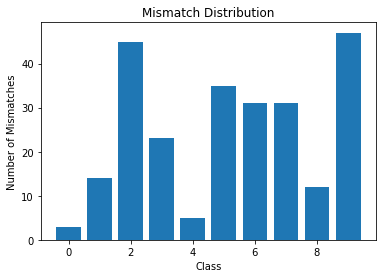

In [116]:
# Display Mismatch Stats
displayMisStats4b = True
if runTask4b and displayMisStats4b:
   myMismatch, badMismatch = calculate_mismatch(x_test4b, y_test, t4bModel)

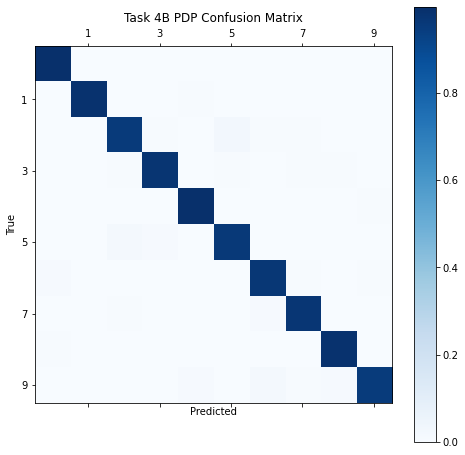

In [117]:
# Plot Confusion Matrix
plotConf4b = True

if runTask4b and plotConf4b:
    y_predict4b = tf.nn.softmax(t4bModel(x_test4b))
    y_classes4b = classes[np.argmax(y_predict4b, axis=1)]
    cm4b = confusion_matrix(y_test,y_classes4b,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4b, cmap=plt.cm.Blues)
    ax.set_title("Task 4B PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task 4C: Flipping and Moving--

In [118]:
runTask4c = True

### Create New Images

In [119]:
# Create new images
if runTask4c:
    nImageNew = nImage*2

    x_train4c = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        fFlip = randint(0,3)
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)

        if fFlip < 2:
            x_train4c[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_train[i,:,:,0]
        elif fFlip == 2:
            flipped = cv2.flip(x_train[i,:,:,0], 0)
            x_train4c[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = flipped[:,:]
        else:
            flipped = cv2.flip(x_train[i,:,:,0], 1)
            x_train4c[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = flipped[:,:]
            
    x_test4c = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        fFlip = randint(0,3)
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)
        
        if fFlip < 2:
            x_test4c[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_test[i,:,:,0]
        elif fFlip == 2:
            flipped = cv2.flip(x_test[i,:,:,0], 0)
            x_test4c[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = flipped[:,:]
        else:
            flipped = cv2.flip(x_test[i,:,:,0], 1)
            x_test4c[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = flipped[:,:]
            
    print('Created Dataset For Task 4C.')

Created Dataset For Task 4C.


Plotting Training Image 21696
Plotting Testing Image 107


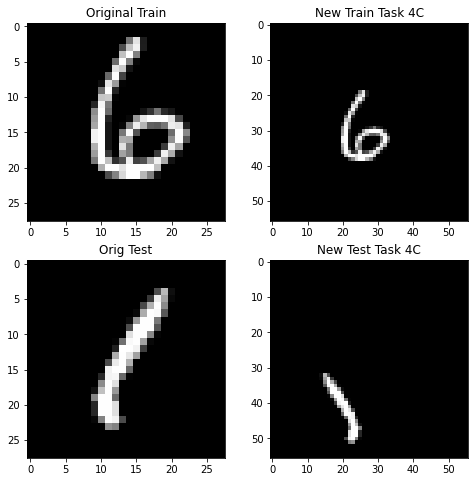

In [120]:
# Plot sample images
plotSample4c = True
if runTask4c and plotSample4c:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    ax1.set_title("Original Train")
    
    imToPlot = x_train4c[imSample1,:,:,0]
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(imToPlot,cmap='gray')
    ax2.set_title("New Train Task 4C")
    
    imToPlot = x_test[imSample2,:,:,0]
    ax3 = plt.subplot(2,2,3)
    ax3.imshow(imToPlot,cmap='gray')
    ax3.set_title("Orig Test")
    
    imToPlot = x_test4c[imSample2,:,:,0]
    ax4 = plt.subplot(2,2,4)
    ax4.imshow(imToPlot,cmap='gray')
    ax4.set_title("New Test Task 4C")

### CNN

In [121]:
# Train CNN
trainModel4c = False
saveModel4c = False
fileModel4c = './save/t4cCNN.json'
fileWghts4c = './save/t4cCNN.h5'

if runTask4c:
    if trainModel4c:
        nEpochs=8
        showSummary4c = False
        t4cModel = cnn_setup(nShape=nImageNew)
    
        if showSummary4c:
            t4cModel.summary()
    
        histMod4c = t4cModel.fit(x_train4c, y_train, 
                              epochs=nEpochs,
                              validation_data=(x_test4c, y_test))
        loss, accuracy = t4cModel.evaluate(x_test4c,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel4c:
            # serialize model to JSON and save weights
            with open(fileModel4c, "w") as json_file:
                json_file.write(t4cModel.to_json())
                t4cModel.save_weights(fileWghts4c)
                print("Saved Task 4C CNN Model to disk")
                
    else:
        json_file4 = open(fileModel4c, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4cModel = models.model_from_json(loaded_model_json)
        t4cModel.load_weights(fileWghts4c)
        print("Loaded Task 4 C CNN Model from disk")
        
        cnn_compile(t4cModel)
        loss4cModTr, acc4cModTr = t4cModel.evaluate(x_train4c, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4cModTr*100.))
        loss4cMod, acc4cMod = t4cModel.evaluate(x_test4c, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4cMod*100.))

Loaded Task 4 C CNN Model from disk
  Train Accuracy: 92.643
  Test Accuracy : 92.840


In [122]:
# Plot Training History
plotTaskHist4c = False
saveTaskHist4c = False
if runTask4c and trainModel4c and plotTaskHist4c:
    plt.plot(histMod4c.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod4c.history['val_accuracy'], label = 'Test Accuracy')
    plt.title('Model History Task 4C')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskHist4c:
        plt.savefig('HistoryT4C.png',bbox_inches='tight')

In [123]:
# Display Mismatches
displayMisMatch4c = False
if runTask4c and displayMisMatch4c:
   display_mismatch(x_test4c, y_test, t4cModel)

Numbers of Mismatches Per Class: [ 27.  24. 123.  38.  73.  76.  99.  89.  30. 137.]
Distributions of Bad Guesses: 
0: [0. 1. 6. 1. 1. 5. 6. 0. 3. 4.] (Total: 27)
1: [3. 0. 4. 1. 2. 0. 1. 7. 3. 3.] (Total: 24)
2: [ 0.  1.  0.  8.  2. 72. 13. 10. 11.  6.] (Total: 123)
3: [ 0.  0. 11.  0.  0. 16.  2.  2.  6.  1.] (Total: 38)
4: [ 0.  1.  6.  0.  0.  0.  4. 11.  7. 44.] (Total: 73)
5: [ 1.  2. 44. 14.  0.  0.  2.  3.  4.  6.] (Total: 76)
6: [ 9.  2. 14.  3.  0.  6.  0. 14.  8. 43.] (Total: 99)
7: [ 4. 12. 31.  6.  3.  6. 14.  0.  0. 13.] (Total: 89)
8: [ 0.  0.  9. 11.  0.  2.  2.  0.  0.  6.] (Total: 30)
9: [ 7.  2. 14.  3.  3. 11. 69.  9. 19.  0.] (Total: 137)


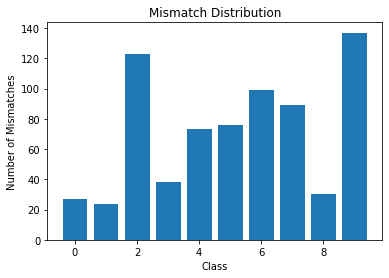

In [124]:
# Display Mismatch Stats
displayMisStats4c = True
if runTask4c and displayMisStats4c:
   myMismatch, badMismatch = calculate_mismatch(x_test4c, y_test, t4cModel)

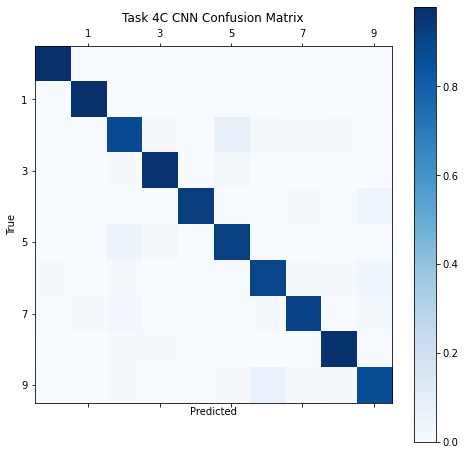

In [125]:
# Plot Confusion Matrix
plotConf4c = True

if runTask4c and plotConf4c:
    y_predict4c = tf.nn.softmax(t4cModel(x_test4c))
    y_classes4c = classes[np.argmax(y_predict4c, axis=1)]
    cm4c = confusion_matrix(y_test,y_classes4c,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4c, cmap=plt.cm.Blues)
    ax.set_title("Task 4C CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [126]:
# Train PDP 
trainPDP4c = False
savePDP4c = False
fileModPDP4c = "./save/t4cPDP.json"
fileWgtPDP4c = "./save/t4cPDP.h5"

if runTask4c:
    if trainPDP4c:
        nEpochs=10
        showSummary4c = False
        t4cModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary4c:
            t4cModPDP.summary()
    
        histPDP4c = t4cModPDP.fit(x_train4c[:,:,:,0], y_train, epochs=nEpochs, 
                                validation_data=(x_test4c[:,:,:,0], y_test))
        loss, accuracy = t4cModPDP.evaluate(x_test4c[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
    
        if savePDP4c:
            # serialize model to JSON and save weights
            with open(fileModPDP4c, "w") as json_file:
                json_file.write(t4cModPDP.to_json())
                t4cModPDP.save_weights(fileWgtPDP4c)
                print("Saved Task4C PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP4c, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4cModPDP = models.model_from_json(loaded_model_json)
        t4cModPDP.load_weights(fileWgtPDP4c)
        print("Loaded Task 4C PDP Model from disk") 
            
        pdp_compile(t4cModPDP)
        loss4cPDPTr, acc4cPDPTr = t4cModPDP.evaluate(x_train4c[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4cPDPTr*100.))
        loss4cPDP, acc4cPDP = t4cModPDP.evaluate(x_test4c[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4cPDP*100.))

Loaded Task 4C PDP Model from disk
  Train Accuracy: 73.523
  Test Accuracy : 74.340


In [128]:
# Plot Training History
plotTaskPDPHist4c = False
saveTaskPDPHist4c = False

if runTask4c and trainPDP4c and plotTaskPDPHist4c:
    plt.plot(histPDP4c.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP4c.history['val_accuracy'], label = 'Test Accuracy')
    plt.title("Task 4C Training History")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskPDPHist4c:
        plt.savefig('HistoryPDP4c.png',bbox_inches='tight')

In [129]:
# Display Mismatches
displayMisMatch4c = False
if runTask4c and displayMisMatch4c:
   display_mismatch(x_test4c, y_test, t4cModPDP)

Numbers of Mismatches Per Class: [ 27.  24. 123.  38.  73.  76.  99.  89.  30. 137.]
Distributions of Bad Guesses: 
0: [0. 1. 6. 1. 1. 5. 6. 0. 3. 4.] (Total: 27)
1: [3. 0. 4. 1. 2. 0. 1. 7. 3. 3.] (Total: 24)
2: [ 0.  1.  0.  8.  2. 72. 13. 10. 11.  6.] (Total: 123)
3: [ 0.  0. 11.  0.  0. 16.  2.  2.  6.  1.] (Total: 38)
4: [ 0.  1.  6.  0.  0.  0.  4. 11.  7. 44.] (Total: 73)
5: [ 1.  2. 44. 14.  0.  0.  2.  3.  4.  6.] (Total: 76)
6: [ 9.  2. 14.  3.  0.  6.  0. 14.  8. 43.] (Total: 99)
7: [ 4. 12. 31.  6.  3.  6. 14.  0.  0. 13.] (Total: 89)
8: [ 0.  0.  9. 11.  0.  2.  2.  0.  0.  6.] (Total: 30)
9: [ 7.  2. 14.  3.  3. 11. 69.  9. 19.  0.] (Total: 137)


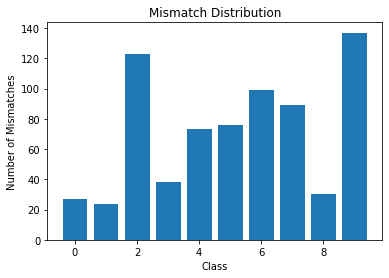

In [130]:
# Display Mismatch Stats
displayMisStats4c = True
if runTask4c and displayMisStats4c:
   myMismatch, badMismatch = calculate_mismatch(x_test4c, y_test, t4cModel)

In [131]:
# Plot Confusion Matrix
plotConf4c = True

if runTask4c and plotConf4c:
    y_predict4c = tf.nn.softmax(t4cModel(x_test4c))
    y_classes4c = classes[np.argmax(y_predict4c, axis=1)]
    cm4c = confusion_matrix(y_test,y_classes4c,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4c, cmap=plt.cm.Blues)
    ax.set_title("Task 4C PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task 4D: Degrading and Moving--

In [132]:
runTask4d = True

### Create New Images

In [133]:
if runTask4d:
    nImageNew = nImage*2

    x_train4d = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)
        imgStart = copy.deepcopy(x_train[i,:,:,0])
        imgRef = np.where(imgStart > 0.)
        nWhite = imgRef[0].shape[0]
        for nw in range(nWhite):
            rWhite = randint(0,2)
            if rWhite == 1:
                imgStart[imgRef[0][nw],imgRef[1][nw]] = 0.
        
        x_train4d[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = imgStart[:,:]

    x_test4d = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)
        imgStart = copy.deepcopy(x_test[i,:,:,0])
        imgRef = np.where(imgStart > 0.)
        nWhite = imgRef[0].shape[0]
        for nw in range(nWhite):
            rWhite = randint(0,2)
            if rWhite == 1:
                imgStart[imgRef[0][nw],imgRef[1][nw]] = 0.
        x_test4d[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = imgStart[:,:]
        
    print('Created Dataset For Task 4D.')

Created Dataset For Task 4D.


Plotting Training Image 29505
Plotting Testing Image 8286


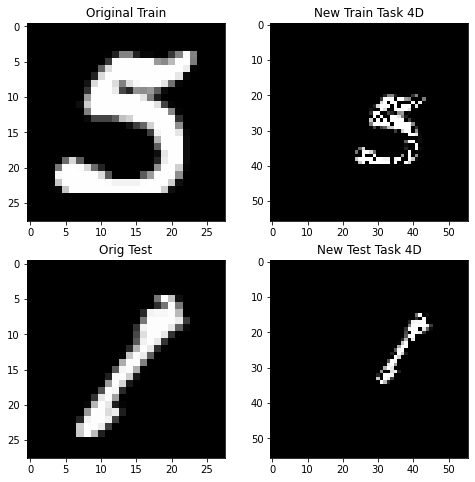

In [134]:
# Plot sample images
plotSample4d = True
if runTask4d and plotSample4d:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    ax1.set_title("Original Train")
    
    imToPlot = x_train4d[imSample1,:,:,0]
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(imToPlot,cmap='gray')
    ax2.set_title("New Train Task 4D")
    
    imToPlot = x_test[imSample2,:,:,0]
    ax3 = plt.subplot(2,2,3)
    ax3.imshow(imToPlot,cmap='gray')
    ax3.set_title("Orig Test")
    
    imToPlot = x_test4d[imSample2,:,:,0]
    ax4 = plt.subplot(2,2,4)
    ax4.imshow(imToPlot,cmap='gray')
    ax4.set_title("New Test Task 4D")

### CNN

In [135]:
# Train CNN
trainModel4d = False
saveModel4d = False
fileModel4d = './save/t4dCNN.json'
fileWghts4d = './save/t4dCNN.h5'

if runTask4d:
    if trainModel4d:
        nEpochs=10
        showSummary4d = False
        t4dModel = cnn_setup(nShape=nImageNew)
    
        if showSummary4d:
            t4dModel.summary()
    
        histMod4d = t4dModel.fit(x_train4d, y_train, 
                              epochs=nEpochs,
                              validation_data=(x_test4d, y_test))
        loss, accuracy = t4dModel.evaluate(x_test4d,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel4d:
            # serialize model to JSON and save weights
            with open(fileModel4d, "w") as json_file:
                json_file.write(t4dModel.to_json())
                t4dModel.save_weights(fileWghts4d)
                print("Saved Task 4D CNN Model to disk")
                
    else:
        json_file4 = open(fileModel4d, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4dModel = models.model_from_json(loaded_model_json)
        t4dModel.load_weights(fileWghts4d)
        print("Loaded Task 4D CNN Model from disk")
        
        cnn_compile(t4dModel)
        loss4dModTr, acc4dModTr = t4dModel.evaluate(x_train4d, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4dModTr*100.))
        loss4dMod, acc4dMod = t4dModel.evaluate(x_test4d, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4dMod*100.))

Loaded Task 4D CNN Model from disk
  Train Accuracy: 96.723
  Test Accuracy : 96.740


In [136]:
# Plot Training History
plotTaskHist4d = False
saveTaskHist4d = False
if runTask4d and trainModel4d and plotTaskHist4d:
    plt.plot(histMod4d.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod4d.history['val_accuracy'], label = 'Test Accuracy')
    plt.title('Model History Task 4D')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskHist4d:
        plt.savefig('HistoryT4D.png',bbox_inches='tight')

In [137]:
# Display Mismatches
displayMisMatch4d = False
if runTask4d and displayMisMatch4d:
   display_mismatch(x_test4d, y_test, t4dModel)

Numbers of Mismatches Per Class: [20. 20. 36. 22. 25. 31. 28. 42. 24. 78.]
Distributions of Bad Guesses: 
0: [0. 0. 5. 0. 0. 1. 7. 4. 2. 1.] (Total: 20)
1: [1. 0. 3. 2. 2. 1. 6. 0. 5. 0.] (Total: 20)
2: [10.  0.  0. 11.  0.  0.  3.  7.  5.  0.] (Total: 36)
3: [ 0.  0.  3.  0.  0. 12.  0.  2.  4.  1.] (Total: 22)
4: [ 1.  1.  3.  0.  0.  0.  5.  1.  4. 10.] (Total: 25)
5: [ 2.  0.  0. 19.  0.  0.  3.  0.  7.  0.] (Total: 31)
6: [9. 3. 1. 0. 5. 3. 0. 0. 7. 0.] (Total: 28)
7: [ 0.  5. 20.  4. 10.  0.  0.  0.  0.  3.] (Total: 42)
8: [5. 1. 5. 4. 1. 3. 3. 0. 0. 2.] (Total: 24)
9: [ 7.  6.  0.  9. 22.  3.  0. 15. 16.  0.] (Total: 78)


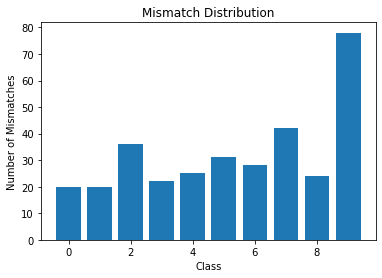

In [138]:
# Display Mismatch Stats
displayMisStats4d = True
if runTask4d and displayMisStats4d:
   myMismatch, badMismatch = calculate_mismatch(x_test4d, y_test, t4dModel)

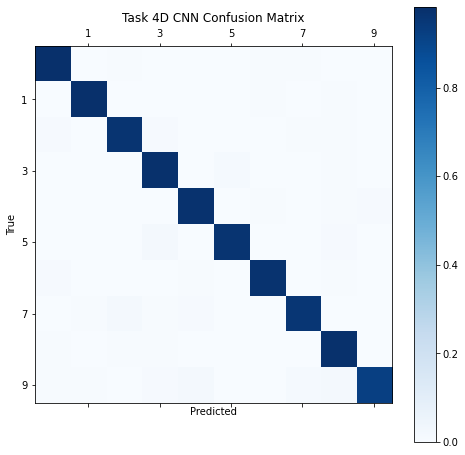

In [139]:
# Plot Confusion Matrix
plotConf4d = True

if runTask4d and plotConf4d:
    y_predict4d = tf.nn.softmax(t4dModel(x_test4d))
    y_classes4d = classes[np.argmax(y_predict4d, axis=1)]
    cm4d = confusion_matrix(y_test,y_classes4d,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4d, cmap=plt.cm.Blues)
    ax.set_title("Task 4D CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [140]:
# Train PDP 
trainPDP4d = False
savePDP4d = False
fileModPDP4d = "./save/t4dPDP.json"
fileWgtPDP4d = "./save/t4dPDP.h5"

if runTask4d:
    if trainPDP4d:
        nEpochs=10
        showSummary4d = False
        t4dModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary4d:
            t4dModPDP.summary()
    
        histPDP4d = t4dModPDP.fit(x_train4d[:,:,:,0], y_train, epochs=nEpochs, 
                                validation_data=(x_test4d[:,:,:,0], y_test))
        loss, accuracy = t4dModPDP.evaluate(x_test4d[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
    
        if savePDP4d:
            # serialize model to JSON and save weights
            with open(fileModPDP4d, "w") as json_file:
                json_file.write(t4dModPDP.to_json())
                t4dModPDP.save_weights(fileWgtPDP4d)
                print("Saved Task4D PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP4d, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4dModPDP = models.model_from_json(loaded_model_json)
        t4dModPDP.load_weights(fileWgtPDP4d)
        print("Loaded Task 4D PDP Model from disk") 
            
        pdp_compile(t4dModPDP)
        loss4dPDPTr, acc4dPDPTr = t4dModPDP.evaluate(x_train4d[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4dPDPTr*100.))
        loss4dPDP, acc4dPDP = t4dModPDP.evaluate(x_test4d[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4dPDP*100.))

Loaded Task 4D PDP Model from disk
  Train Accuracy: 78.827
  Test Accuracy : 79.530


In [141]:
# Plot Training History
plotPDPHist4d = False
savePDPHist4d = False

if runTask4d and trainPDP4d and plotPDPHist4d:
    plt.plot(histPDP4d.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP4d.history['val_accuracy'], label = 'Test Accuracy')
    plt.title("Task 4D Training History")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskPDPHist4d:
        plt.savefig('HistoryPDP4d.png',bbox_inches='tight')

In [142]:
# Display Mismatches
displayMisMatch4d = False
if runTask4d and displayMisMatch4d:
   display_mismatch(x_test4d, y_test, t4dModPDP)

Numbers of Mismatches Per Class: [20. 20. 36. 22. 25. 31. 28. 42. 24. 78.]
Distributions of Bad Guesses: 
0: [0. 0. 5. 0. 0. 1. 7. 4. 2. 1.] (Total: 20)
1: [1. 0. 3. 2. 2. 1. 6. 0. 5. 0.] (Total: 20)
2: [10.  0.  0. 11.  0.  0.  3.  7.  5.  0.] (Total: 36)
3: [ 0.  0.  3.  0.  0. 12.  0.  2.  4.  1.] (Total: 22)
4: [ 1.  1.  3.  0.  0.  0.  5.  1.  4. 10.] (Total: 25)
5: [ 2.  0.  0. 19.  0.  0.  3.  0.  7.  0.] (Total: 31)
6: [9. 3. 1. 0. 5. 3. 0. 0. 7. 0.] (Total: 28)
7: [ 0.  5. 20.  4. 10.  0.  0.  0.  0.  3.] (Total: 42)
8: [5. 1. 5. 4. 1. 3. 3. 0. 0. 2.] (Total: 24)
9: [ 7.  6.  0.  9. 22.  3.  0. 15. 16.  0.] (Total: 78)


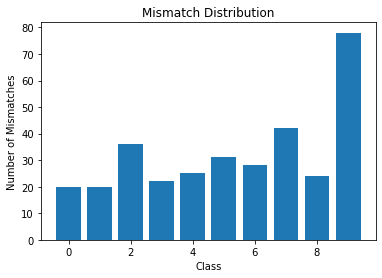

In [143]:
# Display Mismatch Stats
displayMisStats4d = True
if runTask4d and displayMisStats4d:
   myMismatch, badMismatch = calculate_mismatch(x_test4d, y_test, t4dModel)

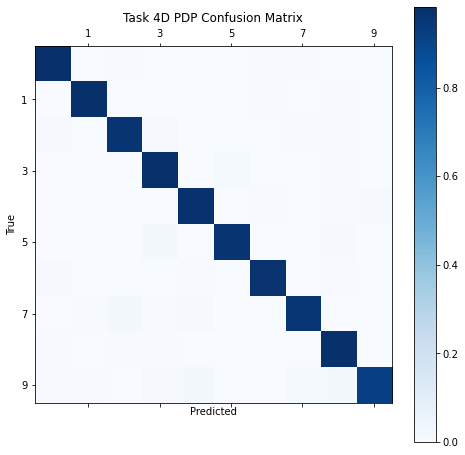

In [144]:
# Plot Confusion Matrix
plotConf4d = True

if runTask4d and plotConf4d:
    y_predict4d = tf.nn.softmax(t4dModel(x_test4d))
    y_classes4d = classes[np.argmax(y_predict4d, axis=1)]
    cm4d = confusion_matrix(y_test,y_classes4d,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4d, cmap=plt.cm.Blues)
    ax.set_title("Task 4D PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task 4E: Warping and Moving--

In [145]:
runTask4e = True

In [146]:
# Create New Images
if runTask4e:
    nImageNew = nImage*2

    x_train4e = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        imgStart = copy.deepcopy(x_train[i,:,:,0])
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)       
        
        pickWarp = randint(0,1)
        myStretch = randint(2,8)
        imgNew = np.zeros([nImage,nImage])
        for ir in range(nImage):
            for jr in range(nImage):

                if pickWarp == 1:
                    offset_x = int(myStretch * np.sin(2 * 3.14 * ir / 24.))
                    if jr+offset_x < nImage and (jr+offset_x) > 0:
                        imgNew[ir,jr] = imgStart[ir,(jr+offset_x)%nImage]
                    else:
                        imgNew[ir,jr] = 0.

                else:
                    offset_y = int(myStretch * np.cos(2 * 3.14 * jr / 24.))
                    if ir+offset_y < nImage and (ir+offset_y) > 0:
                        imgNew[ir,jr] = imgStart[(ir+offset_y)%nImage,jr]
                    else:
                        imgNew[ir,jr] = 0.

        x_train4e[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = imgNew[:,:]

    x_test4e = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        
        imgStart = copy.deepcopy(x_test[i,:,:,0])
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)       

        pickWarp = randint(0,1)
        myStretch = randint(1,6)
        imgNew = np.zeros([nImage,nImage])
        for ir in range(nImage):
            for jr in range(nImage):
            
                if pickWarp == 1:
                    offset_x = int(myStretch * np.sin(2 * 3.14 * ir / 24.))
                    if jr+offset_x < nImage and (jr + offset_x) > 0:
                        imgNew[ir,jr] = imgStart[ir,(jr+offset_x)%nImage]
                    else:
                        imgNew[ir,jr] = 0.

                else:
                    offset_y = int(myStretch * np.cos(2 * 3.14 * jr / 24.))
                    if ir+offset_y < nImage and (ir + offset_y) > 0:
                        imgNew[ir,jr] = imgStart[(ir+offset_y)%nImage,jr]
                    else:
                        imgNew[ir,jr] = 0.
 
        x_test4e[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = imgNew[:,:]
        
    print('Created Dataset For Task 4E.')

Created Dataset For Task 4E.


Plotting Training Image 15576
Plotting Testing Image 9532


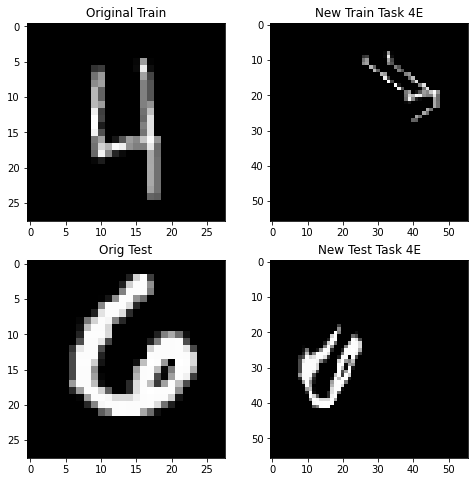

In [147]:
# Plot sample images
plotSample4e = True
if runTask4e and plotSample4e:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    ax1.set_title("Original Train")
    
    imToPlot = x_train4e[imSample1,:,:,0]
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(imToPlot,cmap='gray')
    ax2.set_title("New Train Task 4E")

    imToPlot = x_test[imSample2,:,:,0]
    ax3 = plt.subplot(2,2,3)
    ax3.imshow(imToPlot,cmap='gray')
    ax3.set_title("Orig Test")
    
    imToPlot = x_test4e[imSample2,:,:,0]
    ax4 = plt.subplot(2,2,4)
    ax4.imshow(imToPlot,cmap='gray')
    ax4.set_title("New Test Task 4E")

### CNN

In [148]:
# Train CNN
trainModel4e = False
saveModel4e = False
fileModel4e = './save/t4eCNN.json'
fileWghts4e = './save/t4eCNN.h5'

if runTask4e:
    if trainModel4e:
        nEpochs=10
        showSummary4e = False
        t4eModel = cnn_setup(nShape=nImageNew)
    
        if showSummary4e:
            t4eModel.summary()
    
        histMod4e = t4eModel.fit(x_train4e, y_train, 
                              epochs=nEpochs,
                              validation_data=(x_test4e, y_test))
        loss, accuracy = t4eModel.evaluate(x_test4e,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel4e:
            # serialize model to JSON and save weights
            with open(fileModel4e, "w") as json_file:
                json_file.write(t4eModel.to_json())
                t4eModel.save_weights(fileWghts4e)
                print("Saved Task 4E CNN Model to disk")
                
    else:
        json_file4 = open(fileModel4e, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4eModel = models.model_from_json(loaded_model_json)
        t4eModel.load_weights(fileWghts4e)
        print("Loaded Task 4E CNN Model from disk")
        
        cnn_compile(t4eModel)
        loss4eModTr, acc4eModTr = t4eModel.evaluate(x_train4e, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4eModTr*100.))
        loss4eMod, acc4eMod = t4eModel.evaluate(x_test4e, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4eMod*100.))
        

Loaded Task 4E CNN Model from disk
  Train Accuracy: 95.842
  Test Accuracy : 96.390


In [149]:
# Plot Training History
plotTaskHist4e = False
saveTaskHist4e = False
if runTask4e and trainModel4e and plotTaskHist4e:
    plt.plot(histMod4e.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod4e.history['val_accuracy'], label = 'Test Accuracy')
    plt.title('Model History Task 4E')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskHist4e:
        plt.savefig('HistoryT4E.png',bbox_inches='tight')

In [150]:
# Display Mismatches
displayMisMatch4e = False
if runTask4e and displayMisMatch4e:
   display_mismatch(x_test4e, y_test, t4eModel)

Numbers of Mismatches Per Class: [30. 20. 30. 28. 49. 26. 30. 72. 38. 38.]
Distributions of Bad Guesses: 
0: [0. 0. 8. 1. 0. 0. 8. 1. 6. 6.] (Total: 30)
1: [6. 0. 3. 3. 1. 1. 2. 1. 3. 0.] (Total: 20)
2: [6. 1. 0. 7. 2. 1. 1. 4. 6. 2.] (Total: 30)
3: [ 0.  1.  1.  0.  0. 14.  0.  4.  3.  5.] (Total: 28)
4: [ 0.  3.  9.  1.  0.  0.  8.  4.  2. 22.] (Total: 49)
5: [3. 1. 3. 7. 2. 0. 2. 1. 3. 4.] (Total: 26)
6: [11.  2.  1.  0.  2.  7.  0.  0.  5.  2.] (Total: 30)
7: [ 0.  5. 43.  9.  4.  0.  0.  0.  1. 10.] (Total: 72)
8: [10.  1.  3.  2.  1.  5.  5.  0.  0. 11.] (Total: 38)
9: [ 2.  3.  1.  4.  5. 11.  3.  4.  5.  0.] (Total: 38)


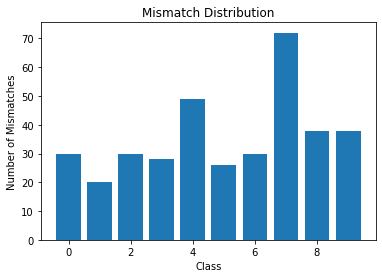

In [151]:
# Display Mismatch Stats
displayMisStats4e = True
if runTask4e and displayMisStats4e:
   myMismatch, badMismatch = calculate_mismatch(x_test4e, y_test, t4eModel)

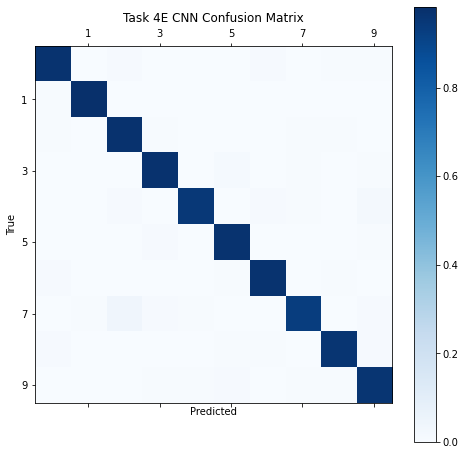

In [152]:
# Plot Confusion Matrix
plotConf4e = True

if runTask4e and plotConf4e:
    y_predict4e = tf.nn.softmax(t4eModel(x_test4e))
    y_classes4e = classes[np.argmax(y_predict4e, axis=1)]
    cm4e = confusion_matrix(y_test,y_classes4e,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4e, cmap=plt.cm.Blues)
    ax.set_title("Task 4E CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [153]:
# Train PDP 
trainPDP4e = False
savePDP4e = False
fileModPDP4e = "./save/t4ePDP.json"
fileWgtPDP4e = "./save/t4ePDP.h5"

if runTask4e:
    if trainPDP4e:
        nEpochs=10
        showSummary4e = False
        t4eModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary4e:
            t4eModPDP.summary()
    
        histPDP4e = t4eModPDP.fit(x_train4e[:,:,:,0], y_train, epochs=nEpochs, 
                                validation_data=(x_test4e[:,:,:,0], y_test))
        loss, accuracy = t4eModPDP.evaluate(x_test4e[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
    
        if savePDP4e:
            # serialize model to JSON and save weights
            with open(fileModPDP4e, "w") as json_file:
                json_file.write(t4eModPDP.to_json())
                t4eModPDP.save_weights(fileWgtPDP4e)
                print("Saved Task4E PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP4e, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4eModPDP = models.model_from_json(loaded_model_json)
        t4eModPDP.load_weights(fileWgtPDP4e)
        print("Loaded Task 4E PDP Model from disk")
        
        pdp_compile(t4eModPDP)
        loss4ePDPTr, acc4ePDPTr = t4eModPDP.evaluate(x_train4e[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4ePDPTr*100.))
        loss4ePDP, acc4ePDP = t4eModPDP.evaluate(x_test4e[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4ePDP*100.))

Loaded Task 4E PDP Model from disk
  Train Accuracy: 74.218
  Test Accuracy : 77.750


In [154]:
# Plot Training History
plotPDPHist4e = False
savePDPHist4e = False

if runTask4e and trainPDP4e and plotPDPHist4e:
    plt.plot(histPDP4e.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP4e.history['val_accuracy'], label = 'Test Accuracy')
    plt.title("Task 4E Training History")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if savePDPHist4e:
        plt.savefig('HistoryPDP4e.png',bbox_inches='tight')

In [155]:
# Display Mismatches
displayMisMatch4e = False
if runTask4e and displayMisMatch4e:
   display_mismatch(x_test4e, y_test, t4eModPDP)

Numbers of Mismatches Per Class: [30. 20. 30. 28. 49. 26. 30. 72. 38. 38.]
Distributions of Bad Guesses: 
0: [0. 0. 8. 1. 0. 0. 8. 1. 6. 6.] (Total: 30)
1: [6. 0. 3. 3. 1. 1. 2. 1. 3. 0.] (Total: 20)
2: [6. 1. 0. 7. 2. 1. 1. 4. 6. 2.] (Total: 30)
3: [ 0.  1.  1.  0.  0. 14.  0.  4.  3.  5.] (Total: 28)
4: [ 0.  3.  9.  1.  0.  0.  8.  4.  2. 22.] (Total: 49)
5: [3. 1. 3. 7. 2. 0. 2. 1. 3. 4.] (Total: 26)
6: [11.  2.  1.  0.  2.  7.  0.  0.  5.  2.] (Total: 30)
7: [ 0.  5. 43.  9.  4.  0.  0.  0.  1. 10.] (Total: 72)
8: [10.  1.  3.  2.  1.  5.  5.  0.  0. 11.] (Total: 38)
9: [ 2.  3.  1.  4.  5. 11.  3.  4.  5.  0.] (Total: 38)


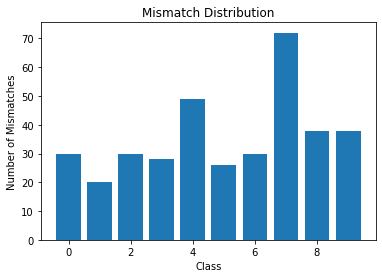

In [156]:
# Display Mismatch Stats
displayMisStats4e = True
if runTask4e and displayMisStats4e:
   myMismatch, badMismatch = calculate_mismatch(x_test4e, y_test, t4eModel)

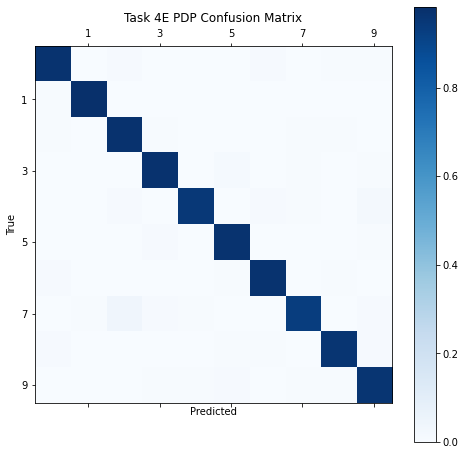

In [157]:
# Plot Confusion Matrix
plotConf4e = True

if runTask4e and plotConf4e:
    y_predict4e = tf.nn.softmax(t4eModel(x_test4e))
    y_classes4e = classes[np.argmax(y_predict4e, axis=1)]
    cm4e = confusion_matrix(y_test,y_classes4e,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4e, cmap=plt.cm.Blues)
    ax.set_title("Task 4E PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task 4F: Test Only Warping and Moving--

In [158]:
runTask4f = True

In [159]:
# Create New Images
if runTask4f:
    nImageNew = nImage*2

    x_train4f = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        iStart = int(nImage/2)-5
        iStop = int(nImage/2)+5
        xstart = randint(iStart,iStop)
        ystart = randint(iStart,iStop)       
        x_train4f[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_train[i,:,:,0]
        
    x_test4f = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        
        imgStart = copy.deepcopy(x_test[i,:,:,0])
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)       

        pickWarp = randint(0,1)
        myStretch = randint(1,6)
        imgNew = np.zeros([nImage,nImage])
        for ir in range(nImage):
            for jr in range(nImage):
            
                if pickWarp == 1:
                    offset_x = int(myStretch * np.sin(2 * 3.14 * ir / 24.))
                    if jr+offset_x < nImage and (jr + offset_x) > 0:
                        imgNew[ir,jr] = imgStart[ir,(jr+offset_x)%nImage]
                    else:
                        imgNew[ir,jr] = 0.

                else:
                    offset_y = int(myStretch * np.cos(2 * 3.14 * jr / 24.))
                    if ir+offset_y < nImage and (ir + offset_y) > 0:
                        imgNew[ir,jr] = imgStart[(ir+offset_y)%nImage,jr]
                    else:
                        imgNew[ir,jr] = 0.
 
        x_test4f[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = imgNew[:,:]
        
    print('Created Dataset For Task 4F.')

Created Dataset For Task 4F.


In [160]:
# Plot sample images
plotSample4f = True
if runTask4f and plotSample4f:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    ax1.set_title("Original Train")
    
    imToPlot = x_train4f[imSample1,:,:,0]
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(imToPlot,cmap='gray')
    ax2.set_title("New Train Task 4F")

    imToPlot = x_test[imSample2,:,:,0]
    ax3 = plt.subplot(2,2,3)
    ax3.imshow(imToPlot,cmap='gray')
    ax3.set_title("Orig Test")
    
    imToPlot = x_test4f[imSample2,:,:,0]
    ax4 = plt.subplot(2,2,4)
    ax4.imshow(imToPlot,cmap='gray')
    ax4.set_title("New Test Task 4F")

Plotting Training Image 10402
Plotting Testing Image 4379


### CNN

In [161]:
# Train CNN
trainModel4f = False
saveModel4f = False
fileModel4f = './save/t4fCNN.json'
fileWghts4f = './save/t4fCNN.h5'

if runTask4f:
    if trainModel4f:
        nEpochs=10
        showSummary4f = False
        t4fModel = cnn_setup(nShape=nImageNew)
    
        if showSummary4f:
            t4fModel.summary()
    
        histMod4f = t4fModel.fit(x_train4f, y_train, 
                              epochs=nEpochs,
                              validation_data=(x_test4f, y_test))
        loss, accuracy = t4fModel.evaluate(x_test4f,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel4f:
            # serialize model to JSON and save weights
            with open(fileModel4f, "w") as json_file:
                json_file.write(t4fModel.to_json())
                t4fModel.save_weights(fileWghts4f)
                print("Saved Task 4F CNN Model to disk")
                
    else:
        json_file4 = open(fileModel4f, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4fModel = models.model_from_json(loaded_model_json)
        t4fModel.load_weights(fileWghts4f)
        print("Loaded Task 4F CNN Model from disk")
        
        cnn_compile(t4fModel)
        loss4fModTr, acc4fModTr = t4fModel.evaluate(x_train4f, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4fModTr*100.))
        loss4fMod, acc4fMod = t4fModel.evaluate(x_test4f, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4fMod*100.))

Loaded Task 4F CNN Model from disk
  Train Accuracy: 98.727
  Test Accuracy : 41.360


In [162]:
# Plot Training History
plotHist4f = False
saveHist4f = False
if runTask4f and trainModel4f and plotHist4f:
    plt.plot(histMod4f.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod4f.history['val_accuracy'], label = 'Test Accuracy')
    plt.title('Model History Task 4F')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveHist4f:
        plt.savefig('HistoryT4F.png',bbox_inches='tight')

In [163]:
# Display Mismatches
displayMisMatch4f = False
if runTask4f and displayMisMatch4f:
   display_mismatch(x_test4f, y_test, t4fModel)

Numbers of Mismatches Per Class: [664. 645. 540. 495. 533. 522. 596. 599. 547. 723.]
Distributions of Bad Guesses: 
0: [  0.  71. 140.  42.  75.  98.  39. 109.  63.  27.] (Total: 664)
1: [122.   0.  47.  57. 197.  24.  80.  81.  10.  27.] (Total: 645)
2: [ 39.  27.   0.  83.  34. 159.  12. 122.  28.  36.] (Total: 540)
3: [ 44.  19. 116.   0.  18. 158.   6.  86.  37.  11.] (Total: 495)
4: [96. 96. 62. 35.  0. 79. 37. 86. 24. 18.] (Total: 533)
5: [ 43.  46. 141.  70.  43.   0.  54.  57.  55.  13.] (Total: 522)
6: [ 67.  81.  50.  17. 130.  68.   0.  67.  68.  48.] (Total: 596)
7: [ 13.  70. 170.  71.  71. 143.  10.   0.  24.  27.] (Total: 599)
8: [ 66.  22.  99.  82.  39. 106.  40.  26.   0.  67.] (Total: 547)
9: [ 72.  24. 126.  47.  81. 109.  49. 141.  74.   0.] (Total: 723)


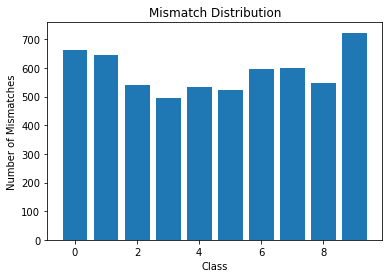

In [164]:
# Display Mismatch Stats
displayMisStats4f = True
if runTask4f and displayMisStats4f:
   myMismatch, badMismatch = calculate_mismatch(x_test4f, y_test, t4fModel)

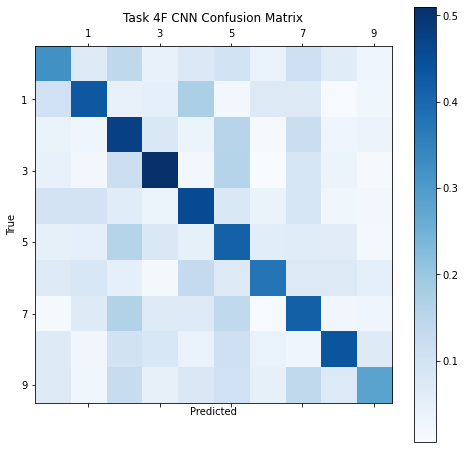

In [165]:
# Plot Confusion Matrix
plotConf4f = True

if runTask4f and plotConf4f:
    y_predict4f = tf.nn.softmax(t4fModel(x_test4f))
    y_classes4f = classes[np.argmax(y_predict4f, axis=1)]
    cm4f = confusion_matrix(y_test,y_classes4f,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4f, cmap=plt.cm.Blues)
    ax.set_title("Task 4F CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP

In [166]:
# Train PDP 
trainPDP4f = False
savePDP4f = False
fileModPDP4f = "./save/t4fPDP.json"
fileWgtPDP4f = "./save/t4fPDP.h5"

if runTask4f:
    if trainPDP4f:
        nEpochs=10
        showSummary4f = False
        t4fModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary4f:
            t4fModPDP.summary()
    
        histPDP4f = t4fModPDP.fit(x_train4f[:,:,:,0], y_train, epochs=nEpochs, 
                                validation_data=(x_test4f[:,:,:,0], y_test))
        loss, accuracy = t4fModPDP.evaluate(x_test4f[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
    
        if savePDP4f:
            # serialize model to JSON and save weights
            with open(fileModPDP4f, "w") as json_file:
                json_file.write(t4fModPDP.to_json())
                t4fModPDP.save_weights(fileWgtPDP4f)
                print("Saved Task4F PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP4f, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4fModPDP = models.model_from_json(loaded_model_json)
        t4fModPDP.load_weights(fileWgtPDP4f)
        print("Loaded Task 4F PDP Model from disk") 
            
        pdp_compile(t4fModPDP)
        loss4fPDPTr, acc4fPDPTr = t4fModPDP.evaluate(x_train4f[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4fPDPTr*100.))
        loss4fPDP, acc4fPDP = t4fModPDP.evaluate(x_test4f[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4fPDP*100.))

Loaded Task 4F PDP Model from disk
  Train Accuracy: 94.430
  Test Accuracy : 26.740


In [167]:
# Plot Training History
plotPDPHist4f = False
savePDPHist4f = False

if runTask4f and trainPDP4f and plotPDPHist4f:
    plt.plot(histPDP4f.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP4f.history['val_accuracy'], label = 'Test Accuracy')
    plt.title("Task 4F Training History")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if savePDPHist4f:
        plt.savefig('HistoryPDP4f.png',bbox_inches='tight')

In [168]:
# Display Mismatches
displayMisMatch4f = False
if runTask4f and displayMisMatch4f:
   display_mismatch(x_test4f, y_test, t4fModPDP)

Numbers of Mismatches Per Class: [664. 645. 540. 495. 533. 522. 596. 599. 547. 723.]
Distributions of Bad Guesses: 
0: [  0.  71. 140.  42.  75.  98.  39. 109.  63.  27.] (Total: 664)
1: [122.   0.  47.  57. 197.  24.  80.  81.  10.  27.] (Total: 645)
2: [ 39.  27.   0.  83.  34. 159.  12. 122.  28.  36.] (Total: 540)
3: [ 44.  19. 116.   0.  18. 158.   6.  86.  37.  11.] (Total: 495)
4: [96. 96. 62. 35.  0. 79. 37. 86. 24. 18.] (Total: 533)
5: [ 43.  46. 141.  70.  43.   0.  54.  57.  55.  13.] (Total: 522)
6: [ 67.  81.  50.  17. 130.  68.   0.  67.  68.  48.] (Total: 596)
7: [ 13.  70. 170.  71.  71. 143.  10.   0.  24.  27.] (Total: 599)
8: [ 66.  22.  99.  82.  39. 106.  40.  26.   0.  67.] (Total: 547)
9: [ 72.  24. 126.  47.  81. 109.  49. 141.  74.   0.] (Total: 723)


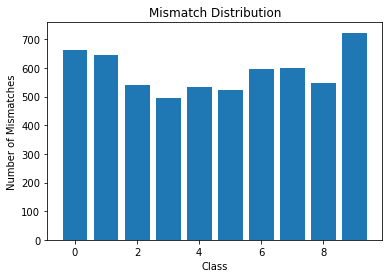

In [169]:
# Display Mismatch Stats
displayMisStats4f = True
if runTask4f and displayMisStats4f:
   myMismatch, badMismatch = calculate_mismatch(x_test4f, y_test, t4fModel)

In [170]:
# Plot Confusion Matrix
plotConf4f = True

if runTask4f and plotConf4f:
    y_predict4f = tf.nn.softmax(t4fModel(x_test4f))
    y_classes4f = classes[np.argmax(y_predict4f, axis=1)]
    cm4f = confusion_matrix(y_test,y_classes4f,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4f, cmap=plt.cm.Blues)
    ax.set_title("Task 4F PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

# --Task 4G: Train Only Warping and Moving--

In [171]:
runTask4g = True

In [172]:
# Create New Images
if runTask4g:
    nImageNew = nImage*2

    x_test4g = np.zeros([nTest,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTest):
        iStart = int(nImage/2)-5
        iStop = int(nImage/2)+5
        xstart = randint(iStart,iStop)
        ystart = randint(iStart,iStop)       
        x_test4g[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = x_test[i,:,:,0]
        
    x_train4g = np.zeros([nTrain,nImageNew,nImageNew,1],dtype='float32')
    for i in range(nTrain):
        
        imgStart = copy.deepcopy(x_train[i,:,:,0])
        xstart = randint(0,nImage)
        ystart = randint(0,nImage)       

        pickWarp = randint(0,1)
        myStretch = randint(1,6)
        imgNew = np.zeros([nImage,nImage])
        for ir in range(nImage):
            for jr in range(nImage):
            
                if pickWarp == 1:
                    offset_x = int(myStretch * np.sin(2 * 3.14 * ir / 24.))
                    if jr+offset_x < nImage and (jr + offset_x) > 0:
                        imgNew[ir,jr] = imgStart[ir,(jr+offset_x)%nImage]
                    else:
                        imgNew[ir,jr] = 0.

                else:
                    offset_y = int(myStretch * np.cos(2 * 3.14 * jr / 24.))
                    if ir+offset_y < nImage and (ir + offset_y) > 0:
                        imgNew[ir,jr] = imgStart[(ir+offset_y)%nImage,jr]
                    else:
                        imgNew[ir,jr] = 0.
 
        x_train4g[i,xstart:xstart+nImage,ystart:ystart+nImage,0] = imgNew[:,:]
        
    print('Created Dataset For Task 4G.')

Created Dataset For Task 4G.


In [173]:
# Plot sample images
plotSample4g = True
if runTask4g and plotSample4g:
    imSample1 = randint(0,nTrain-1)
    imSample2 = randint(0,nTest-1)
    print("Plotting Training Image {}".format(imSample1))
    print("Plotting Testing Image {}".format(imSample2))
    
    imToPlot = x_train[imSample1,:,:,0]
    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(imToPlot,cmap='gray')
    ax1.set_title("Original Train")
    
    imToPlot = x_train4g[imSample1,:,:,0]
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(imToPlot,cmap='gray')
    ax2.set_title("New Train Task 4G")

    imToPlot = x_test[imSample2,:,:,0]
    ax3 = plt.subplot(2,2,3)
    ax3.imshow(imToPlot,cmap='gray')
    ax3.set_title("Orig Test")
    
    imToPlot = x_test4g[imSample2,:,:,0]
    ax4 = plt.subplot(2,2,4)
    ax4.imshow(imToPlot,cmap='gray')
    ax4.set_title("New Test Task 4G")

Plotting Training Image 25606
Plotting Testing Image 1363


### CNN

In [174]:
# Train CNN
trainModel4g = False
saveModel4g = True
fileModel4g = './save/t4gCNN.json'
fileWghts4g = './save/t4gCNN.h5'

if runTask4g:
    if trainModel4g:
        nEpochs=10
        showSummary4g = False
        t4gModel = cnn_setup(nShape=nImageNew)
    
        if showSummary4g:
            t4gModel.summary()
    
        histMod4g = t4gModel.fit(x_train4g, y_train, 
                              epochs=nEpochs,
                              validation_data=(x_test4g, y_test))
        loss, accuracy = t4fModel.evaluate(x_test4g,  y_test, verbose=2)
        print()
        print("The CNN is trained to {:.3f}% test accuracy.".format(accuracy*100))
        
        if saveModel4g:
            # serialize model to JSON and save weights
            with open(fileModel4g, "w") as json_file:
                json_file.write(t4gModel.to_json())
                t4gModel.save_weights(fileWghts4g)
                print("Saved Task 4G CNN Model to disk")
                
    else:
        json_file4 = open(fileModel4g, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4gModel = models.model_from_json(loaded_model_json)
        t4gModel.load_weights(fileWghts4g)
        print("Loaded Task 4G CNN Model from disk")
        
        cnn_compile(t4gModel)
        loss4gModTr, acc4gModTr = t4gModel.evaluate(x_train4g, y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4gModTr*100.))
        loss4gMod, acc4gMod = t4gModel.evaluate(x_test4g, y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4gMod*100.))

Loaded Task 4G CNN Model from disk
  Train Accuracy: 96.608
  Test Accuracy : 97.630


In [175]:
# Plot Training History
plotTaskHist4g = True
saveTaskHist4g = True
if runTask4g and trainModel4g and plotTaskHist4g:
    plt.plot(histMod4g.history['accuracy'], label='Train Accuracy')
    plt.plot(histMod4g.history['val_accuracy'], label = 'Test Accuracy')
    plt.title('Model History Task 4G')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if saveTaskHist4g:
        plt.savefig('HistoryT4g.png',bbox_inches='tight')

In [176]:
# Display Mismatches
displayMisMatch4g = True
if runTask4g and displayMisMatch4g:
   display_mismatch(x_test4g, y_test, t4gModel)

Displaying 237 mismatches
Press q to exit at any time...
Done


Numbers of Mismatches Per Class: [34.  7. 13. 12. 34. 22. 14. 41. 18. 42.]
Distributions of Bad Guesses: 
0: [ 0.  2.  5.  1.  1.  1.  9.  3. 12.  0.] (Total: 34)
1: [1. 0. 2. 1. 1. 0. 0. 0. 2. 0.] (Total: 7)
2: [0. 2. 0. 2. 0. 1. 1. 1. 6. 0.] (Total: 13)
3: [0. 0. 2. 0. 0. 7. 0. 1. 2. 0.] (Total: 12)
4: [ 0.  6.  1.  0.  0.  0.  2.  5.  2. 18.] (Total: 34)
5: [ 1.  2.  0. 10.  2.  0.  1.  3.  3.  0.] (Total: 22)
6: [2. 3. 0. 0. 1. 5. 0. 0. 3. 0.] (Total: 14)
7: [ 0.  6. 25.  5.  2.  0.  0.  0.  1.  2.] (Total: 41)
8: [2. 1. 3. 1. 1. 3. 5. 0. 0. 2.] (Total: 18)
9: [ 0.  6.  0.  3.  7.  0.  0. 10. 16.  0.] (Total: 42)


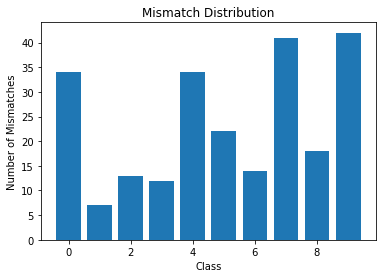

In [177]:
# Display Mismatch Stats
displayMisStats4g = True
saveMisStats4g = False
if runTask4g and displayMisStats4g:
   myMismatch, badMismatch = calculate_mismatch(x_test4g, y_test, 
                                                t4gModel, save=saveMisStats4g)

In [178]:
# Plot Confusion Matrix
plotConf4g = True

if runTask4g and plotConf4g:
    y_predict4g = tf.nn.softmax(t4gModel(x_test4g))
    y_classes4g = classes[np.argmax(y_predict4g, axis=1)]
    cm4g = confusion_matrix(y_test,y_classes4g,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4g, cmap=plt.cm.Blues)
    ax.set_title("Task 4G CNN Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### PDP Neural Network

In [179]:
# Train PDP 
trainPDP4g = False
savePDP4g = False
fileModPDP4g = "./save/t4gPDP.json"
fileWgtPDP4g = "./save/t4gPDP.h5"

if runTask4g:
    if trainPDP4g:
        nEpochs=10
        showSummary4g = False
        t4gModPDP = pdp_setup(nShape=nImageNew)
    
        if showSummary4g:
            t4gModPDP.summary()
    
        histPDP4g = t4gModPDP.fit(x_train4g[:,:,:,0], y_train, epochs=nEpochs, 
                                validation_data=(x_test4g[:,:,:,0], y_test))
        loss, accuracy = t4gModPDP.evaluate(x_test4g[:,:,:,0],  y_test, verbose=2)
        print()
        print("The PDP NN is trained to {:.3f}% test accuracy.".format(accuracy*100))
    
        if savePDP4g:
            # serialize model to JSON and save weights
            with open(fileModPDP4g, "w") as json_file:
                json_file.write(t4gModPDP.to_json())
                t4gModPDP.save_weights(fileWgtPDP4g)
                print("Saved Task4G PDP Model to disk")
            
    else:
        json_file4 = open(fileModPDP4g, 'r')
        loaded_model_json = json_file4.read()
        json_file4.close()
        t4gModPDP = models.model_from_json(loaded_model_json)
        t4gModPDP.load_weights(fileWgtPDP4g)
        print("Loaded Task 4G PDP Model from disk") 
            
        pdp_compile(t4gModPDP)
        loss4gPDPTr, acc4gPDPTr = t4gModPDP.evaluate(x_train4g[:,:,:,0], 
                                                     y_train, verbose=0)
        print("  Train Accuracy: {:.3f}".format(acc4gPDPTr*100.))
        loss4gPDP, acc4gPDP = t4gModPDP.evaluate(x_test4g[:,:,:,0], 
                                                y_test, verbose=0)
        print("  Test Accuracy : {:.3f}".format(acc4gPDP*100.))

Loaded Task 4G PDP Model from disk
  Train Accuracy: 78.553
  Test Accuracy : 84.540


In [180]:
# Plot Training History
plotPDPHist4g = False
savePDPHist4g = False

if runTask4g and trainPDP4g and plotPDPHist4g:
    plt.plot(histPDP4g.history['accuracy'], label='Train Accuracy')
    plt.plot(histPDP4g.history['val_accuracy'], label = 'Test Accuracy')
    plt.title("Task 4G Training History")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='center right')
    
    if savePDPHist4g:
        plt.savefig('HistoryPDP4g.png',bbox_inches='tight')

In [181]:
# Display Mismatches
displayMisMatch4g = False
if runTask4g and displayMisMatch4g:
   display_mismatch(x_test4g, y_test, t4gModPDP)

Numbers of Mismatches Per Class: [111.  18. 144. 218. 171. 204. 102. 176. 230. 172.]
Distributions of Bad Guesses: 
0: [ 0.  5. 23.  7.  7.  7. 27.  6. 27.  2.] (Total: 111)
1: [1. 0. 5. 1. 0. 3. 2. 1. 5. 0.] (Total: 18)
2: [15.  4.  0. 61.  4. 20.  7. 14. 17.  2.] (Total: 144)
3: [10.  9. 43.  0.  1. 56.  0. 29. 48. 22.] (Total: 218)
4: [  2.   2.   5.   0.   0.   2.  27.   5.   2. 126.] (Total: 171)
5: [18.  7. 31. 63.  3.  0.  3. 27. 30. 22.] (Total: 204)
6: [25. 10. 31.  1.  8. 18.  0.  0.  9.  0.] (Total: 102)
7: [ 3. 27. 21. 33.  6.  5.  0.  0. 12. 69.] (Total: 176)
8: [49. 18.  8. 37.  7. 46. 20.  9.  0. 36.] (Total: 230)
9: [11. 16.  0. 15. 70. 13.  0. 32. 15.  0.] (Total: 172)


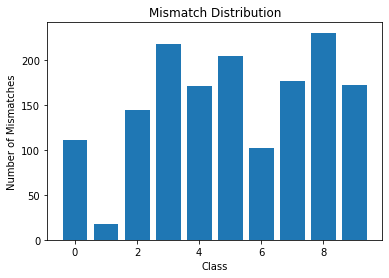

In [182]:
# Display Mismatch Stats
displayMisStats4g = True
saveMisStats4g = False
if runTask4g and displayMisStats4g:
   myMismatch, badMismatch = calculate_mismatch(x_test4g, y_test, 
                                                t4gModPDP, save=saveMisStats4g)

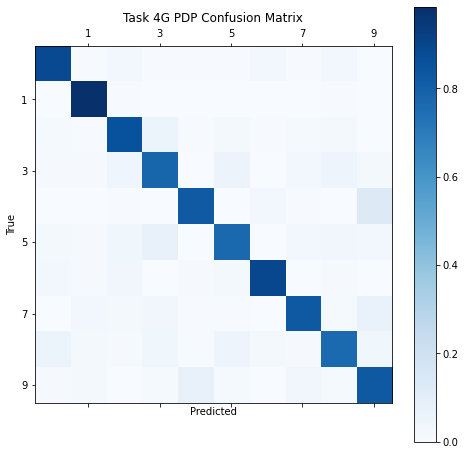

In [183]:
# Plot Confusion Matrix
plotConf4g = True

if runTask4g and plotConf4g:
    y_predict4g = tf.nn.softmax(t4gModPDP(x_test4g))
    y_classes4g = classes[np.argmax(y_predict4g, axis=1)]
    cm4g = confusion_matrix(y_test,y_classes4g,normalize='true')

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm4g, cmap=plt.cm.Blues)
    ax.set_title("Task 4G PDP Confusion Matrix")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([1,3,5,7,9])
    ax.set_xticklabels(['1','3','5','7','9'])
    ax.set_yticks([1,3,5,7,9])
    ax.set_yticklabels(['1','3','5','7','9'])
    fig.colorbar(cax)
    plt.show()

### Both CNN and PDP

In [184]:
# Show a sample box plot of two models
showBothModels4G = True
saveBothModels4G = True
if showBothModels4G:
    yclasses = np.array([0,1,2,3,4,5,6,7,8,9])
    myMismatches1 = [28.,13.,16.,10.,29.,13.,16.,50.,14.,38.]
    myMismatches2 = [102.,20.,156.,230.,194.,191.,123.,171.,235.,183.]

    if False:
        sum1 = sum(myMismatches1)
        sum2 = sum(myMismatches2)
        for i in range(len(myMismatches1)):
            myMismatches1[i] /= sum1
            myMismatches2[i] /= sum2
        
    width=0.4
    nClasses = yclasses.shape[0]
    ind = np.arange(nClasses)-width/2.
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, myMismatches1, width, label="CNN")
    rects2 = ax.bar(ind+width, myMismatches2, width, label="PDP")

    plt.title("Mismatch Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Mismatches")
    plt.legend()
    
    if saveBothModels4G:
        plt.savefig('misBar2.png',bbox_inches='tight')
    else:
        plt.show()